In [1]:
# import packages

In [2]:
from pandas.io.json import json_normalize
import json
from pandasql import sqldf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import io
import requests
import json
import base64
import datetime
from urllib.parse import urlencode

In [3]:
# client id

In [4]:
client_id = '6e24789ec7874259a220f747fcd7e93e'
client_secret = '9bd8ff1ad2f34ef6a87f00124be070b2'

In [5]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"



    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def getClientCreds(self):
        '''Returns b64 encoded string'''
        client_id = self.client_id
        client_secret = self.client_secret

        if client_id == None or client_secret == None:
            raise Exception('Must set a client id and secret')

        client_creds  = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()

    def getTokenHeader(self):
        client_creds_b64 = self.getClientCreds()
        return {
            'Authorization':f"Basic {client_creds_b64}"
        }

    def getTokenData(self):
        return {
            "grant_type":"client_credentials"
        }

    def perform_auth(self):
        token_url = self.token_url
        token_data = self.getTokenData()
        token_header = self.getTokenHeader()

        r = requests.post(token_url, data=token_data, headers=token_header)

        if r.status_code  not in range(200,299):
            raise Exception('Could not authenticate client.')
            #return False

        now = datetime.datetime.now()
        token_response_data = r.json()
        access_token = token_response_data['access_token']
        expires_in = token_response_data['expires_in']
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now


        return True

    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now= datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}", 
        }
        return headers
    
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f'https://api.spotify.com/{version}/{resource_type}/{lookup_id}'
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers = headers)
        if r.status_code not in range (200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id ):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id ):
        return self.get_resource(_id, resource_type='artists')
    
    def get_playlist(self, _id):
        return self.get_resource(_id, resource_type='playlists')
    
    def get_genre(self, _id):
        return self.get_resource(_id, resource_type='genres')
    
    
    def base_search(self, query_params): #type
        access_token = self.get_access_token()
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_URL = f"{endpoint}?{query_params}"
        r = requests.get(lookup_URL, headers=headers)
        if r.status_code not in range (200, 299):
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist'):
        if query == None:
            raise Exception('A query is required')
        if isinstance(query, dict):
            query = ' '.join([f'{k}:{v}' for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == 'or' or operator.lower() == 'not':
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f'{query} {operator} {operator_query}'
        query_params = urlencode({'q': query, 'type': search_type.lower()})
        return self.base_search(query_params)

In [6]:
spotify = SpotifyAPI(client_id, client_secret)

In [ ]:
# Top Weeks Streams

In [177]:
top_weeks_stream = pd.read_csv('../data/top_weeks_stream_2.csv')
print(top_weeks_stream)

       name  Song                                              album  \
0  concat_1     0  {'album_type': 'album', 'artists': [{'external...   
1  concat_1     1  {'album_type': 'album', 'artists': [{'external...   
2  concat_1     2  {'album_type': 'album', 'artists': [{'external...   
3  concat_1     3  {'album_type': 'album', 'artists': [{'external...   
4  concat_1     4  {'album_type': 'compilation', 'artists': [{'ex...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0                                       ['CA', 'US']            1   
1  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
2  ['AD', 'AE', 'AG', '

In [178]:
top_weeks_stream_df = top_weeks_stream[['name.1', 'streams']]
top_weeks_stream_df

,name.1,streams
0,Radioactive,"1,442,672,579"
1,Sail,"709,596,791"
2,I'm Yours,"1,484,482,331"
3,Blinding Lights,"3,302,055,414"
4,How Do I Live,"162,216,076"


# Top Weeks #1 SQL

In [7]:
#project csv

In [8]:
project_csv = pd.read_csv('../data/Hot-Stuff.csv')
print(project_csv)

                                                      url      WeekID  \
0       http://www.billboard.com/charts/hot-100/1965-0...   7/17/1965   
1       http://www.billboard.com/charts/hot-100/1965-0...   7/24/1965   
2       http://www.billboard.com/charts/hot-100/1965-0...   7/31/1965   
3       http://www.billboard.com/charts/hot-100/1965-0...    8/7/1965   
4       http://www.billboard.com/charts/hot-100/1965-0...   8/14/1965   
...                                                   ...         ...   
327890  https://www.billboard.com/charts/hot-100/2018-...  10/20/2018   
327891  http://www.billboard.com/charts/hot-100/1977-0...   5/21/1977   
327892  http://www.billboard.com/charts/hot-100/1981-0...   5/23/1981   
327893  http://www.billboard.com/charts/hot-100/1973-0...   9/29/1973   
327894  https://www.billboard.com/charts/hot-100/2020-...  11/28/2020   

        Week Position                      Song                  Performer  \
0                  34    Don't Just Stand The

In [9]:
# Top Weeks BPM

In [10]:
top_weeks_csv = pd.read_csv('../data/top_weeks_BPM_2.csv')
print(top_weeks_csv)

       name  Song                                              album  \
0  concat_1     0  {'album_type': 'album', 'artists': [{'external...   
1  concat_1     1  {'album_type': 'album', 'artists': [{'external...   
2  concat_1     2  {'album_type': 'album', 'artists': [{'external...   
3  concat_1     3  {'album_type': 'album', 'artists': [{'external...   
4  concat_1     4  {'album_type': 'compilation', 'artists': [{'ex...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0                                       ['CA', 'US']            1   
1  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
2  ['AD', 'AE', 'AG', '

In [11]:
top_weeks_csv_df = top_weeks_csv[['name.1', 'BPM']]
top_weeks_csv_df

,name.1,BPM
0,Radioactive,136
1,Sail,119
2,I'm Yours,151
3,Blinding Lights,171
4,How Do I Live,128


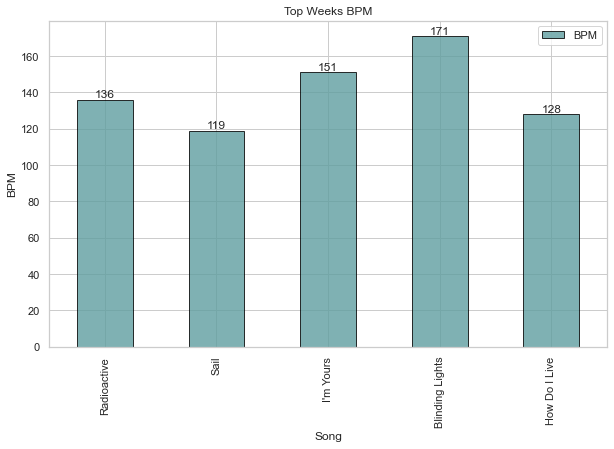

In [162]:
top_weeks_BPM_graph = top_weeks_csv_df.plot(figsize=(10,6),
                             x= 'name.1',
                             y= 'BPM',
                             title = 'Top Weeks BPM',
                             xlabel = 'Song',
                             ylabel = 'BPM',
                             kind = 'bar',
                             color = 'cadetblue',
                             edgecolor = 'black',
                             alpha = 0.8)
for bars in top_weeks_BPM_graph.containers:
    top_weeks_BPM_graph.bar_label(bars)
plt.show()

In [13]:
# Top weeks at 1 BPM

In [14]:
top_1_weeks_csv = pd.read_csv('../data/top_1_weeks_bpm.csv')
print(top_1_weeks_csv)

       name  Song                                              album  \
0  concat_1     0  {'album_type': 'single', 'artists': [{'externa...   
1  concat_1     1  {'album_type': 'album', 'artists': [{'external...   
2  concat_1     2  {'album_type': 'album', 'artists': [{'external...   
3  concat_1     3  {'album_type': 'single', 'artists': [{'externa...   
4  concat_1     4  {'album_type': 'album', 'artists': [{'external...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
1  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
2  ['AD', 'AE', 'AG', '

In [15]:
top_weeks_1_csv_df = top_1_weeks_csv[['name.1', 'BPM']]
top_weeks_1_csv_df

,name.1,BPM
0,Old Town Road - Remix,136
1,One Sweet Day,128
2,Despacito,89
3,Candle In The Wind 1997,126
4,Macarena,103


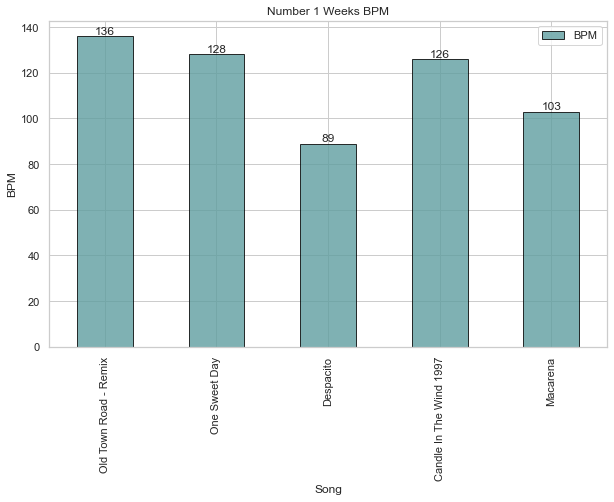

In [163]:
top_1_weeks_BPM_graph = top_weeks_1_csv_df.plot(figsize=(10,6),
                             x= 'name.1',
                             y= 'BPM',
                             title = 'Number 1 Weeks BPM',
                             xlabel = 'Song',
                             ylabel = 'BPM',
                             kind = 'bar',
                             color = 'cadetblue',
                             edgecolor = 'black',
                             alpha = 0.8)
for bars in top_1_weeks_BPM_graph.containers:
    top_1_weeks_BPM_graph.bar_label(bars)
plt.show()

In [17]:
#project_csv_df

In [18]:
project_csv_df = project_csv[['Song', 'Performer', 'Weeks on Chart', 'Week Position', 'WeekID']]
project_csv_df

,Song,Performer,Weeks on Chart,Week Position,WeekID
0,Don't Just Stand There,Patty Duke,4,34,7/17/1965
1,Don't Just Stand There,Patty Duke,5,22,7/24/1965
2,Don't Just Stand There,Patty Duke,6,14,7/31/1965
3,Don't Just Stand There,Patty Duke,7,10,8/7/1965
4,Don't Just Stand There,Patty Duke,8,8,8/14/1965
...,...,...,...,...,...
327890,God Is A Woman,Ariana Grande,13,22,10/20/2018
327891,I Wanna Get Next To You,Rose Royce,13,22,5/21/1977
327892,I Can't Stand It,Eric Clapton And His Band,13,22,5/23/1981
327893,Here I Am Come & Take Me,Al Green,13,22,9/29/1973


In [19]:
# rename

In [20]:
project_csv_df.rename(columns = {'Week Position' : 'WeekPosition', 'Weeks on Chart' : 'WeeksonChart'}, inplace=True)
project_csv_df

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/1831510081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_csv_df.rename(columns = {'Week Position' : 'WeekPosition', 'Weeks on Chart' : 'WeeksonChart'}, inplace=True)


,Song,Performer,WeeksonChart,WeekPosition,WeekID
0,Don't Just Stand There,Patty Duke,4,34,7/17/1965
1,Don't Just Stand There,Patty Duke,5,22,7/24/1965
2,Don't Just Stand There,Patty Duke,6,14,7/31/1965
3,Don't Just Stand There,Patty Duke,7,10,8/7/1965
4,Don't Just Stand There,Patty Duke,8,8,8/14/1965
...,...,...,...,...,...
327890,God Is A Woman,Ariana Grande,13,22,10/20/2018
327891,I Wanna Get Next To You,Rose Royce,13,22,5/21/1977
327892,I Can't Stand It,Eric Clapton And His Band,13,22,5/23/1981
327893,Here I Am Come & Take Me,Al Green,13,22,9/29/1973


In [21]:
position_project=project_csv_df.sort_values(by=['WeekPosition', 'WeeksonChart'], ascending=[True, False])
position_project

,Song,Performer,WeeksonChart,WeekPosition,WeekID
284597,Macarena (Bayside Boys Mix),Los Del Rio,46,1,11/2/1996
284588,Macarena (Bayside Boys Mix),Los Del Rio,45,1,10/26/1996
284578,Macarena (Bayside Boys Mix),Los Del Rio,44,1,10/19/1996
284567,Macarena (Bayside Boys Mix),Los Del Rio,43,1,10/12/1996
284555,Macarena (Bayside Boys Mix),Los Del Rio,42,1,10/5/1996
...,...,...,...,...,...
294181,You Better Know It,Jackie Wilson,1,100,9/5/1959
294476,You Can Do Magic,Limmie & Family Cookin',1,100,11/18/1972
295049,You Don't Have To Be A Tower Of Strength,Gloria Lynne,1,100,12/16/1961
295146,You Don't Know Her Like I Do,Brantley Gilbert,1,100,10/1/2011


In [22]:
# Position SQL

In [23]:
position = 'SELECT Song, Performer, WeeksonChart, WeekPosition FROM position_project WHERE WeekPosition = 1'
sqldf(position, globals())
position_df = sqldf(position, globals())
position_df

,Song,Performer,WeeksonChart,WeekPosition
0,Macarena (Bayside Boys Mix),Los Del Rio,46,1
1,Macarena (Bayside Boys Mix),Los Del Rio,45,1
2,Macarena (Bayside Boys Mix),Los Del Rio,44,1
3,Macarena (Bayside Boys Mix),Los Del Rio,43,1
4,Macarena (Bayside Boys Mix),Los Del Rio,42,1
...,...,...,...,...
3274,We R Who We R,Ke$ha,1,1
3275,What Do You Mean?,Justin Bieber,1,1
3276,What's Next,Drake,1,1
3277,Willow,Taylor Swift,1,1


In [24]:
#position_project.drop_values()

In [25]:
position_drop= position_df.drop(position_project.columns[[2, 3]], axis=1)
position_drop

,Song,Performer
0,Macarena (Bayside Boys Mix),Los Del Rio
1,Macarena (Bayside Boys Mix),Los Del Rio
2,Macarena (Bayside Boys Mix),Los Del Rio
3,Macarena (Bayside Boys Mix),Los Del Rio
4,Macarena (Bayside Boys Mix),Los Del Rio
...,...,...
3274,We R Who We R,Ke$ha
3275,What Do You Mean?,Justin Bieber
3276,What's Next,Drake
3277,Willow,Taylor Swift


In [26]:
# drop

In [27]:
position_1 =position_drop[['Song', 'Performer']].value_counts()
position_1

Song                                                              Performer                                        
Old Town Road                                                     Lil Nas X Featuring Billy Ray Cyrus                  19
One Sweet Day                                                     Mariah Carey & Boyz II Men                           16
Despacito                                                         Luis Fonsi & Daddy Yankee Featuring Justin Bieber    16
Candle In The Wind 1997/Something About The Way You Look Tonight  Elton John                                           14
Macarena (Bayside Boys Mix)                                       Los Del Rio                                          14
                                                                                                                       ..
Lose You To Love Me                                               Selena Gomez                                          1
Looks Like We Made It         

In [28]:
# head(5)

In [29]:
position_top_5= position_1.head(5)
position_top_5

Song                                                              Performer                                        
Old Town Road                                                     Lil Nas X Featuring Billy Ray Cyrus                  19
One Sweet Day                                                     Mariah Carey & Boyz II Men                           16
Despacito                                                         Luis Fonsi & Daddy Yankee Featuring Justin Bieber    16
Candle In The Wind 1997/Something About The Way You Look Tonight  Elton John                                           14
Macarena (Bayside Boys Mix)                                       Los Del Rio                                          14
dtype: int64

In [30]:
position_df_5 = pd.DataFrame(position_top_5)
position_df_5

,,0
Song,Performer,
Old Town Road,Lil Nas X Featuring Billy Ray Cyrus,19
One Sweet Day,Mariah Carey & Boyz II Men,16
Despacito,Luis Fonsi & Daddy Yankee Featuring Justin Bieber,16
Candle In The Wind 1997/Something About The Way You Look Tonight,Elton John,14
Macarena (Bayside Boys Mix),Los Del Rio,14


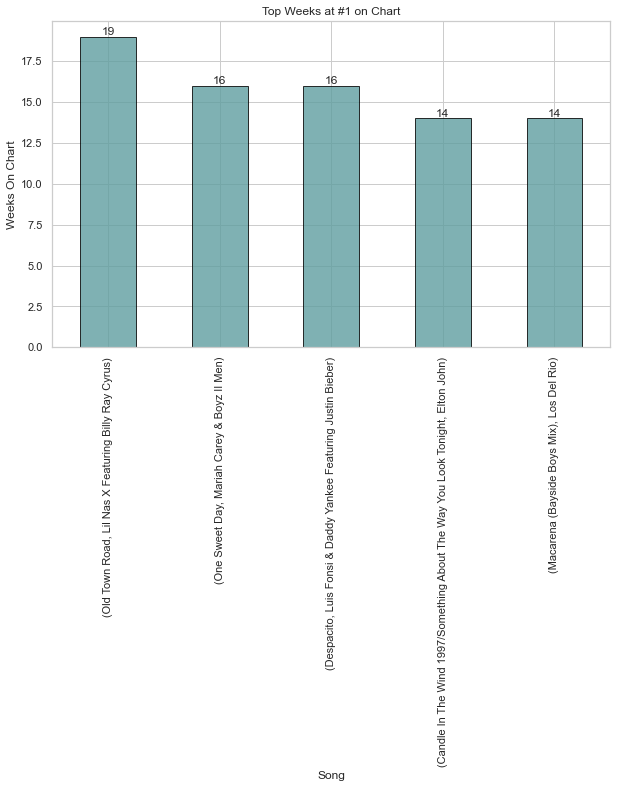

In [161]:
position_graph = position_top_5.plot(figsize=(10,6),
                             x= 'Song',
                             y= 'WeeksonChart',
                             title = 'Top Weeks at #1 on Chart',
                             xlabel = 'Song',
                             ylabel = 'Weeks On Chart',
                             kind = 'bar',
                             color = 'cadetblue',
                             edgecolor = 'black',
                             alpha = 0.8)
for bars in position_graph.containers:
    position_graph.bar_label(bars)
plt.show()

# Top 1 Year Chart

In [33]:
top_1_years = pd.read_csv('../data/top_1_weeks_year_3.csv')
print(top_1_years)

       name  Song                                              album  \
0  concat_1     4  {'album_type': 'album', 'artists': [{'external...   
1  concat_1     1  {'album_type': 'album', 'artists': [{'external...   
2  concat_1     3  {'album_type': 'single', 'artists': [{'externa...   
3  concat_1     2  {'album_type': 'album', 'artists': [{'external...   
4  concat_1     0  {'album_type': 'single', 'artists': [{'externa...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
1  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
2  ['AD', 'AE', 'AG', '

In [34]:
top_1_year_csv_df = top_1_years[['name.1', 'release_year']]
top_1_year_csv_df

,name.1,release_year
0,Macarena,1994
1,One Sweet Day,1995
2,Candle In The Wind 1997,1997
3,Despacito,2017
4,Old Town Road - Remix,2019


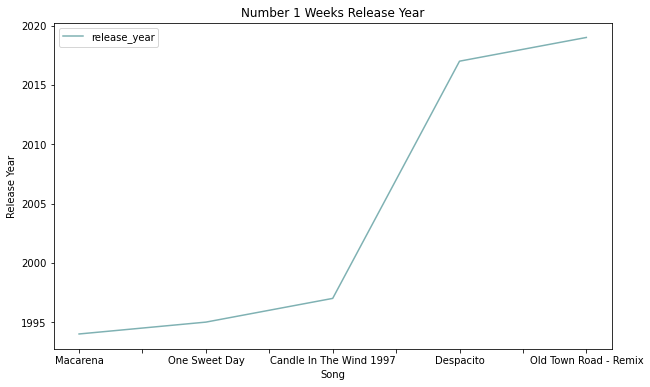

In [35]:
top_weeks_1_graph = top_1_year_csv_df.plot(figsize=(10,6),
                             x= 'name.1',
                             y= 'release_year',
                             title = 'Number 1 Weeks Release Year',
                             xlabel = 'Song',
                             ylabel = 'Release Year',
                             kind = 'line',
                             color = 'cadetblue',
                             
                             alpha = 0.8)
for bars in top_weeks_1_graph.containers:
    top_weeks_1_graph.bar_label(bars)
plt.show()

In [36]:
# top weeks years

In [37]:
top_years = pd.read_csv('../data/top_weeks_year_2.csv')
print(top_years)

       name  Song                                              album  \
0  concat_1     4  {'album_type': 'compilation', 'artists': [{'ex...   
1  concat_1     2  {'album_type': 'album', 'artists': [{'external...   
2  concat_1     1  {'album_type': 'album', 'artists': [{'external...   
3  concat_1     0  {'album_type': 'album', 'artists': [{'external...   
4  concat_1     3  {'album_type': 'album', 'artists': [{'external...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
1  ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...            1   
2  ['AD', 'AE', 'AG', '

In [38]:
top_year_csv_df = top_years[['name.1', 'release_year']]
top_year_csv_df

,name.1,release_year
0,How Do I Live,1997
1,I'm Yours,2008
2,Sail,2010
3,Radioactive,2012
4,Blinding Lights,2019


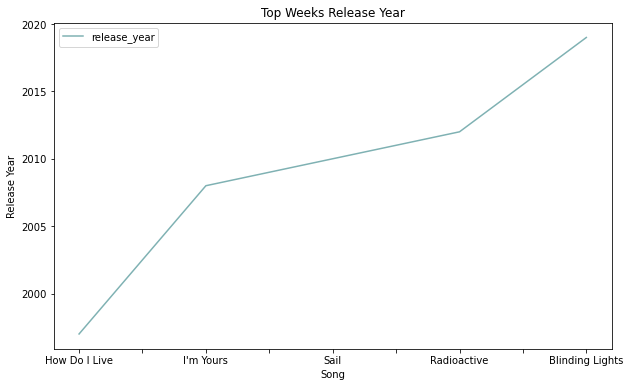

In [39]:
top_weeks_graph = top_year_csv_df.plot(figsize=(10,6),
                             x= 'name.1',
                             y= 'release_year',
                             title = 'Top Weeks Release Year',
                             xlabel = 'Song',
                             ylabel = 'Release Year',
                             kind = 'line',
                             color = 'cadetblue',
                             
                             alpha = 0.8)
for bars in top_weeks_graph.containers:
    top_weeks_graph.bar_label(bars)
plt.show()

# Weeks on Chart SQL

In [40]:
#sort_values Weeks on Chart

In [41]:
sorted_project=project_csv_df.sort_values(by='WeeksonChart', ascending=False)
sorted_project

,Song,Performer,WeeksonChart,WeekPosition,WeekID
302681,Radioactive,Imagine Dragons,87,49,5/10/2014
302680,Radioactive,Imagine Dragons,86,48,5/3/2014
302679,Radioactive,Imagine Dragons,85,42,4/26/2014
302678,Radioactive,Imagine Dragons,84,39,4/19/2014
302677,Radioactive,Imagine Dragons,83,37,4/12/2014
...,...,...,...,...,...
52135,Leave Me Alone,NF,1,85,8/10/2019
52136,In My Room,Frank Ocean,1,85,11/16/2019
52137,Long RD,YoungBoy Never Broke Again,1,85,3/7/2020
292327,XanaX Damage,Future,1,98,6/22/2019


In [42]:
#sort_drop

In [43]:
sort_drop= sorted_project.drop(sorted_project.columns[[2, 3, 4]], axis=1)
sort_drop

,Song,Performer
302681,Radioactive,Imagine Dragons
302680,Radioactive,Imagine Dragons
302679,Radioactive,Imagine Dragons
302678,Radioactive,Imagine Dragons
302677,Radioactive,Imagine Dragons
...,...,...
52135,Leave Me Alone,NF
52136,In My Room,Frank Ocean
52137,Long RD,YoungBoy Never Broke Again
292327,XanaX Damage,Future


In [44]:
# Weeks on Chart count

In [45]:
weeks_drop= sort_drop[['Song', 'Performer']].value_counts()
weeks_drop

Song                   Performer      
Radioactive            Imagine Dragons    87
Sail                   AWOLNATION         79
I'm Yours              Jason Mraz         76
Blinding Lights        The Weeknd         76
How Do I Live          LeAnn Rimes        69
                                          ..
The Plan               Travis Scott        1
Faraway Star           The Chordettes      1
The Plan               G-Eazy              1
Make You Feel My Love  Glee Cast           1
Stockholm Syndrome     One Direction       1
Length: 29389, dtype: int64

In [46]:
weeks_top_5 = weeks_drop.head(5)

In [47]:
weeks_df_5 = pd.DataFrame(weeks_top_5)
weeks_df_5

,,0
Song,Performer,
Radioactive,Imagine Dragons,87
Sail,AWOLNATION,79
I'm Yours,Jason Mraz,76
Blinding Lights,The Weeknd,76
How Do I Live,LeAnn Rimes,69


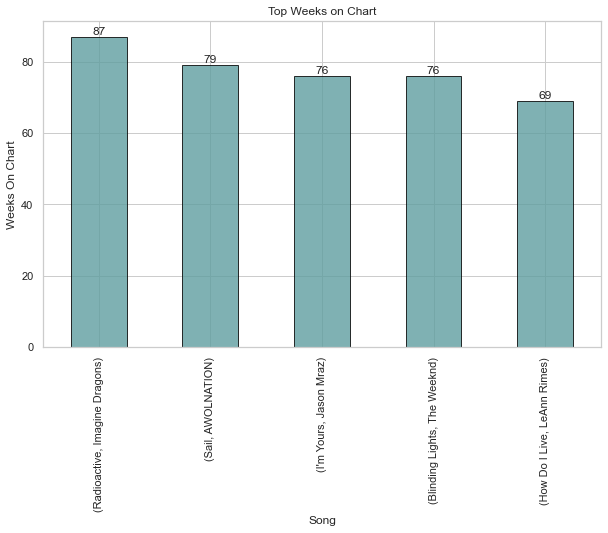

In [164]:
weeks_graph = weeks_top_5.plot(figsize=(10,6),
                             x= 'Song',
                             y= 'WeeksonChart',
                             title = 'Top Weeks on Chart',
                             xlabel = 'Song',
                             ylabel = 'Weeks On Chart',
                             kind = 'bar',
                             color = 'cadetblue',
                             edgecolor = 'black',
                             alpha = 0.8)
for bars in weeks_graph.containers:
    weeks_graph.bar_label(bars)
plt.show()

# Top Weeks

# 1 radioactive

In [49]:
radioactive = spotify.search({'track': 'Radioactive', 'artist': 'Imagine'}, search_type ='track')
radioactive

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ARadioactive+artist%3AImagine&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/53XhwfbYqKCa1cC15pYq2q'},
       'href': 'https://api.spotify.com/v1/artists/53XhwfbYqKCa1cC15pYq2q',
       'id': '53XhwfbYqKCa1cC15pYq2q',
       'name': 'Imagine Dragons',
       'type': 'artist',
       'uri': 'spotify:artist:53XhwfbYqKCa1cC15pYq2q'}],
     'available_markets': ['CA', 'US'],
     'external_urls': {'spotify': 'https://open.spotify.com/album/6htgf3qv7vGcsdxLCDxKp8'},
     'href': 'https://api.spotify.com/v1/albums/6htgf3qv7vGcsdxLCDxKp8',
     'id': '6htgf3qv7vGcsdxLCDxKp8',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b273b2b2747c89d2157b0b29fb6a',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e02b2b2747c89d2157b0b29fb6a',
      

In [50]:
test = pd.DataFrame.from_dict(radioactive,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,156


In [51]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'album', 'artists': [..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'album', 'artists': [..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'album', 'artists': [..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [53]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[CA, US]",1,186813,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/4G...,https://api.spotify.com/v1/tracks/4G8gkOterJn0...,4G8gkOterJn0Ywt6uhqbhp,False,Radioactive,73,https://p.scdn.co/mp3-preview/43288a26d88c84b0...,1,track,spotify:track:4G8gkOterJn0Ywt6uhqbhp
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,276040,True,{'isrc': 'USUM71400693'},{'spotify': 'https://open.spotify.com/track/69...,https://api.spotify.com/v1/tracks/69yfbpvmkIaB...,69yfbpvmkIaB10msnKT7Q5,False,Radioactive,66,https://p.scdn.co/mp3-preview/4a93ec26bf1ef918...,1,track,spotify:track:69yfbpvmkIaB10msnKT7Q5
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[MX, US]",1,186813,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/58...,https://api.spotify.com/v1/tracks/58rFzMvW9kxN...,58rFzMvW9kxNwMtGTgBQoP,False,Radioactive,64,https://p.scdn.co/mp3-preview/43288a26d88c84b0...,1,track,spotify:track:58rFzMvW9kxNwMtGTgBQoP
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,186813,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/5Y...,https://api.spotify.com/v1/tracks/5Yj7eY0cs6wk...,5Yj7eY0cs6wkGsn5mxy9j1,False,Radioactive,54,https://p.scdn.co/mp3-preview/1c6ea8da9a90a318...,1,track,spotify:track:5Yj7eY0cs6wkGsn5mxy9j1
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,188000,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/33...,https://api.spotify.com/v1/tracks/33DPHYA8bJst...,33DPHYA8bJstGIMXkz1lFt,False,Radioactive,42,https://p.scdn.co/mp3-preview/4b9f38fd712765b7...,22,track,spotify:track:33DPHYA8bJstGIMXkz1lFt
5,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",3,270080,False,{'isrc': 'USUM71303062'},{'spotify': 'https://open.spotify.com/track/3T...,https://api.spotify.com/v1/tracks/3T09JC1tNKcH...,3T09JC1tNKcHZPhisKKUm8,False,Radioactive - Live London Sessions / 2013,49,https://p.scdn.co/mp3-preview/e6df45f1c34c71af...,13,track,spotify:track:3T09JC1tNKcHZPhisKKUm8
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AT, AU, BE, CA, CH, CW, DE, DK, EE, ES, F...",1,270160,False,{'isrc': 'USUM71303062'},{'spotify': 'https://open.spotify.com/track/7u...,https://api.spotify.com/v1/tracks/7ukrAoAILpGP...,7ukrAoAILpGPHaZ9uYmNL0,False,Radioactive - Live London Sessions / 2013,40,https://p.scdn.co/mp3-preview/d09e038a79ba0570...,1,track,spotify:track:7ukrAoAILpGPHaZ9uYmNL0
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, BB, BE, BF, BH, BY, CA, DZ, EG, ES, FR, G...",1,276040,False,{'isrc': 'USUM71400767'},{'spotify': 'https://open.spotify.com/track/5e...,https://api.spotify.com/v1/tracks/5e3HJBYbAVb8...,5e3HJBYbAVb83D85z8k60X,False,Radioactive,30,https://p.scdn.co/mp3-preview/8449c5f0273bb35b...,1,track,spotify:track:5e3HJBYbAVb83D85z8k60X
8,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",3,403693,False,{'isrc': 'USUM71400273'},{'spotify': 'https://open.spotify.com/track/2o...,https://api.spotify.com/v1/tracks/2oWTWONg6QFS...,2oWTWONg6QFSwKAPqmBszv,False,Radioactive - Live From Red Rocks / 2014,42,https://p.sc

In [54]:
radio_df = test3.head(1)

#  2 sail

In [55]:
sail = spotify.search({'track': 'Sail', 'artist': 'AWOL'}, search_type ='track')
sail

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ASail+artist%3AAWOL&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4njdEjTnLfcGImKZu1iSrz'},
       'href': 'https://api.spotify.com/v1/artists/4njdEjTnLfcGImKZu1iSrz',
       'id': '4njdEjTnLfcGImKZu1iSrz',
       'name': 'AWOLNATION',
       'type': 'artist',
       'uri': 'spotify:artist:4njdEjTnLfcGImKZu1iSrz'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
  

In [56]:
test = pd.DataFrame.from_dict(sail,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,None
offset,0
previous,None
total,16


In [57]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'album', 'artists': [..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'album', 'artists': [..."
5,"{'album': {'album_type': 'single', 'artists': ..."
6,"{'album': {'album_type': 'album', 'artists': [..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'album', 'artists': [..."


In [59]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,259093,False,{'isrc': 'USP6L1000053'},{'spotify': 'https://open.spotify.com/track/7u...,https://api.spotify.com/v1/tracks/7ueP5u2qkdZb...,7ueP5u2qkdZbIPN2YA6LR0,False,Sail,74,https://p.scdn.co/mp3-preview/39fe4367061eac83...,10,track,spotify:track:7ueP5u2qkdZbIPN2YA6LR0
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,209276,False,{'isrc': 'USP6L1280129'},{'spotify': 'https://open.spotify.com/track/24...,https://api.spotify.com/v1/tracks/24mf5NTXbNe1...,24mf5NTXbNe1de7w6rjaEn,False,Sail - Feed Me Remix,54,https://p.scdn.co/mp3-preview/a6e773d08a3ea3c2...,39,track,spotify:track:24mf5NTXbNe1de7w6rjaEn
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,349654,False,{'isrc': 'USP6L1180110'},{'spotify': 'https://open.spotify.com/track/3k...,https://api.spotify.com/v1/tracks/3kX6cdhy9XQB...,3kX6cdhy9XQBPL81GvEt0Q,False,Sail - Unlimited Gravity Remix,46,https://p.scdn.co/mp3-preview/72f0893e5def96e4...,41,track,spotify:track:3kX6cdhy9XQBPL81GvEt0Q
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,349537,False,{'isrc': 'USP6L1180110'},{'spotify': 'https://open.spotify.com/track/7q...,https://api.spotify.com/v1/tracks/7qAWdfgvuDJQ...,7qAWdfgvuDJQlhjppYtAfA,False,Sail - Unlimited Gravity Remix,43,https://p.scdn.co/mp3-preview/9ae4e713856763d3...,1,track,spotify:track:7qAWdfgvuDJQlhjppYtAfA
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,240779,False,{'isrc': 'USP6L1380136'},{'spotify': 'https://open.spotify.com/track/5G...,https://api.spotify.com/v1/tracks/5GChOpEKNxYX...,5GChOpEKNxYXIRUxto2bWp,False,Sail (feat. Kendrick Lamar & Ab Soul) - TDE Remix,42,https://p.scdn.co/mp3-preview/a5081f7e73252f8c...,40,track,spotify:track:5GChOpEKNxYXIRUxto2bWp
5,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,261046,False,{'isrc': 'USP6L1180113'},{'spotify': 'https://open.spotify.com/track/1D...,https://api.spotify.com/v1/tracks/1DqGEFrotFhh...,1DqGEFrotFhhPsowbbiSJf,False,Sail - LED Remix,31,https://p.scdn.co/mp3-preview/dfcba7af50b33b9e...,4,track,spotify:track:1DqGEFrotFhhPsowbbiSJf
6,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,259092,False,{'isrc': 'USP6L1000053'},{'spotify': 'https://open.spotify.com/track/5U...,https://api.spotify.com/v1/tracks/5UGE88CogQMc...,5UGE88CogQMcdsQhwhSZce,False,Sail,30,https://p.scdn.co/mp3-preview/15d4731f7d1f1cb9...,10,track,spotify:track:5UGE88CogQMcdsQhwhSZce
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,278482,False,{'isrc': 'USP6L1380130'},{'spotify': 'https://open.spotify.com/track/5n...,https://api.spotify.com/v1/tracks/5n41rCn10JV7...,5n41rCn10JV7WwvgoxYY24,False,Sail - Borgore Pop the Sweating I'm Sailing Remix,22,https://p.scdn.co/mp3-preview/8a07c59856308ddf...,37,track,spotify:track:5n41rCn10JV7WwvgoxYY24
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,286959,False,{'isrc': 'USP6L1180112'},{'spotify': 'https://open.spotify.com/track/

In [60]:
sail_df = test3.head(1)

# 3  I'm Yours

In [61]:
Im_Yours = spotify.search({'track': 'Im Yours', 'artist': 'Jason'}, search_type ='track')
Im_Yours

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AIm+Yours+artist%3AJason&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4phGZZrJZRo4ElhRtViYdl'},
       'href': 'https://api.spotify.com/v1/artists/4phGZZrJZRo4ElhRtViYdl',
       'id': '4phGZZrJZRo4ElhRtViYdl',
       'name': 'Jason Mraz',
       'type': 'artist',
       'uri': 'spotify:artist:4phGZZrJZRo4ElhRtViYdl'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ

In [62]:
test = pd.DataFrame.from_dict(Im_Yours,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,215


In [63]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'compilation', 'artis..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'album', 'artists': [..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [65]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,242946,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/1E...,https://api.spotify.com/v1/tracks/1EzrEOXmMH3G...,1EzrEOXmMH3G43AXT1y7pA,False,I'm Yours,80,https://p.scdn.co/mp3-preview/975f7acc6041b1b7...,2,track,spotify:track:1EzrEOXmMH3G43AXT1y7pA
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AZ, BA, BB, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/5C...,https://api.spotify.com/v1/tracks/5CK2LlO2Sh6j...,5CK2LlO2Sh6jEO7kA57OlA,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,35,track,spotify:track:5CK2LlO2Sh6jEO7kA57OlA
2,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AR, AT, AZ, BA, BB, BD, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/5y...,https://api.spotify.com/v1/tracks/5yN0joyoafLX...,5yN0joyoafLXaHve9yMrN5,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,70,track,spotify:track:5yN0joyoafLXaHve9yMrN5
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AM, AU, AZ, BD, BG, BH, BI, BN, BT, BW, C...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/6J...,https://api.spotify.com/v1/tracks/6JzU7Ezgo0w1...,6JzU7Ezgo0w1u3aPFlMl1v,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,17,track,spotify:track:6JzU7Ezgo0w1u3aPFlMl1v
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AZ, BA, BB, BD, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/43...,https://api.spotify.com/v1/tracks/4366rhvlGfjd...,4366rhvlGfjdLFH73X0tQV,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,18,track,spotify:track:4366rhvlGfjdLFH73X0tQV
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/3H...,https://api.spotify.com/v1/tracks/3HN0AC9gB2DJ...,3HN0AC9gB2DJjOlPsI25br,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,63,track,spotify:track:3HN0AC9gB2DJjOlPsI25br
6,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,243941,False,{'isrc': 'USEE11400815'},{'spotify': 'https://open.spotify.com/track/1j...,https://api.spotify.com/v1/tracks/1j5cGcXWdHKT...,1j5cGcXWdHKTPQ2XgXODJI,False,I'm Yours - Live on HSN Live,55,https://p.scdn.co/mp3-preview/9204645792ba99b5...,6,track,spotify:track:1j5cGcXWdHKTPQ2XgXODJI
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[CA, US]",1,242946,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/36...,https://api.spotify.com/v1/tracks/36j4mlX0IWUt...,36j4mlX0IWUtWlWqiwvWXI,False,I'm Yours,34,https://p.scdn.co/mp3-preview/975f7acc6041b1b7...,2,track,spotify:track:36j4mlX0IWUtWlWqiwvWXI
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, BO, BR, BZ, CA, CL, CO, CR, DO, EC, GT, G...",1,242946,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57URzGoYgSj0...,57URzGoYgSj0AiXclvqD6y,False,I'm Yours,34,https://p.scdn.co/mp3-preview/975f7acc6041b1b7...,1,track,sp

In [66]:
yours_df = test3.head(1)

# 4 Blinding Lights

In [67]:
Blinding_Lights = spotify.search({'track': 'Blinding Lights', 'artist': 'The'}, search_type ='track')
Blinding_Lights

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ABlinding+Lights+artist%3AThe&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ'},
       'href': 'https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ',
       'id': '1Xyo4u8uXC1ZmMpatF05PJ',
       'name': 'The Weeknd',
       'type': 'artist',
       'uri': 'spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
    

In [68]:
test = pd.DataFrame.from_dict(Blinding_Lights,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,209


In [69]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'compilation', 'artis..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'compilation', 'artis..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [71]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,200040,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0V...,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,0VjIjW4GlUZAMYd2vXMi3b,False,Blinding Lights,91,https://p.scdn.co/mp3-preview/579494c4709a8cc9...,9,track,spotify:track:0VjIjW4GlUZAMYd2vXMi3b
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0G...,https://api.spotify.com/v1/tracks/0GbnoR2Z5Sg2...,0GbnoR2Z5Sg2j42EdcTU9F,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,4,track,spotify:track:0GbnoR2Z5Sg2j42EdcTU9F
2,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0w...,https://api.spotify.com/v1/tracks/0wvrycgQfH4s...,0wvrycgQfH4svzA4IM0p8S,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,5,track,spotify:track:0wvrycgQfH4svzA4IM0p8S
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0n...,https://api.spotify.com/v1/tracks/0naVx9FzYlE0...,0naVx9FzYlE0aJv4uaegHl,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,11,track,spotify:track:0naVx9FzYlE0aJv4uaegHl
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/1y...,https://api.spotify.com/v1/tracks/1yhPHuDyYVHi...,1yhPHuDyYVHi9EtTRzjpEx,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,11,track,spotify:track:1yhPHuDyYVHi9EtTRzjpEx
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/7G...,https://api.spotify.com/v1/tracks/7GkJMWlQfkER...,7GkJMWlQfkERJFT81ptWr5,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,13,track,spotify:track:7GkJMWlQfkERJFT81ptWr5
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0k...,https://api.spotify.com/v1/tracks/0k0HVjt1hUSB...,0k0HVjt1hUSB1i74oO1l0Z,False,Blinding Lights,4,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,3,track,spotify:track:0k0HVjt1hUSB1i74oO1l0Z
7,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/5I...,https://api.spotify.com/v1/tracks/5IatMb7tZdKB...,5IatMb7tZdKBSd5ro6R8ic,False,Blinding Lights,1,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,14,track,spotify:track:5IatMb7tZdKBSd5ro6R8ic
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/2H...,https://api.spotify.com/v1/tracks/2HdgAjQMeTBu...,2HdgAjQMeTBuGNCNPETL1b,False,Blindi

In [72]:
blinding_df = test3.head(1)

# 5 How Do I Live

In [73]:
How_Do_I = spotify.search({'track': 'How Do I Live', 'artist': 'LeAnn'}, search_type ='track')
How_Do_I

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AHow+Do+I+Live+artist%3ALeAnn&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'compilation',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2d3VHzlOEwXvmBdS4pzOPL'},
       'href': 'https://api.spotify.com/v1/artists/2d3VHzlOEwXvmBdS4pzOPL',
       'id': '2d3VHzlOEwXvmBdS4pzOPL',
       'name': 'LeAnn Rimes',
       'type': 'artist',
       'uri': 'spotify:artist:2d3VHzlOEwXvmBdS4pzOPL'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY

In [74]:
test = pd.DataFrame.from_dict(How_Do_I,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'compilation', 'arti..."
limit,20
next,None
offset,0
previous,None
total,19


In [75]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'compilation', 'artis..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'album', 'artists': [..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [77]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/7B...,https://api.spotify.com/v1/tracks/7BD50ATrF3Va...,7BD50ATrF3Vab5FQy7vtK8,False,How Do I Live,69,https://p.scdn.co/mp3-preview/0e4c7f08abdc62b2...,2,track,spotify:track:7BD50ATrF3Vab5FQy7vtK8
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/6l...,https://api.spotify.com/v1/tracks/6lo9DfMREEeZ...,6lo9DfMREEeZaWWU6KSYp5,False,How Do I Live,51,https://p.scdn.co/mp3-preview/0e4c7f08abdc62b2...,5,track,spotify:track:6lo9DfMREEeZaWWU6KSYp5
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,297573,False,{'isrc': 'USCRB9700028'},{'spotify': 'https://open.spotify.com/track/7j...,https://api.spotify.com/v1/tracks/7jVkRbHbcw9w...,7jVkRbHbcw9wO5tNlBOiWR,False,How Do I Live - Extended Mix,39,https://p.scdn.co/mp3-preview/c2a34a15e858acb3...,10,track,spotify:track:7jVkRbHbcw9wO5tNlBOiWR
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,237266,False,{'isrc': 'USCRB9800029'},{'spotify': 'https://open.spotify.com/track/4t...,https://api.spotify.com/v1/tracks/4tPtLVyfmEJX...,4tPtLVyfmEJXidbOBaQh9Q,False,How Do I Live - Mr. Mig Dance Radio Edit,25,https://p.scdn.co/mp3-preview/406a0016776bd1e9...,1,track,spotify:track:4tPtLVyfmEJXidbOBaQh9Q
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/3c...,https://api.spotify.com/v1/tracks/3cttTBTDdlH8...,3cttTBTDdlH8RViYAMtQr7,False,How Do I Live,18,https://p.scdn.co/mp3-preview/f5149834fbbfcbac...,3,track,spotify:track:3cttTBTDdlH8RViYAMtQr7
5,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,389723,False,{'isrc': 'USCRB1411024'},{'spotify': 'https://open.spotify.com/track/2P...,https://api.spotify.com/v1/tracks/2PrSAncf7v07...,2PrSAncf7v07Nnnzf4WxdF,False,How Do I Live - Cahill Remix,19,https://p.scdn.co/mp3-preview/7f03a4768677edb3...,9,track,spotify:track:2PrSAncf7v07Nnnzf4WxdF
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/6J...,https://api.spotify.com/v1/tracks/6JWARUUOCJ15...,6JWARUUOCJ15T2Rx88Ldfp,False,How Do I Live,14,https://p.scdn.co/mp3-preview/0e4c7f08abdc62b2...,1,track,spotify:track:6JWARUUOCJ15T2Rx88Ldfp
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,258431,False,{'isrc': 'QZBV91800002'},{'spotify': 'https://open.spotify.com/track/7e...,https://api.spotify.com/v1/tracks/7eJuKKES6Uqi...,7eJuKKES6UqidFF8FRdPNP,False,How Do I Live - Re-Imagined,14,https://p.scdn.co/mp3-preview/74b80f8555c0da0d...,1,track,spotify:track:7eJuKKES6UqidFF8FRdPNP
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,258432,False,{'isrc': 'QZBV91800002'},{'spotify': 'https://open.spotify.com/track/3E...,https://api.spotify.com/v1

In [78]:
how_df = test3.head(1)

In [79]:
#concat df

In [80]:
concat = pd.concat([radio_df, sail_df, yours_df, blinding_df, how_df], ignore_index=True)

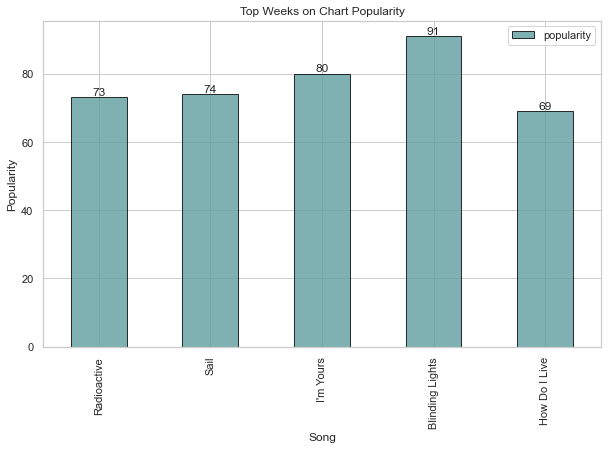

In [165]:
concat_graph = concat.plot(figsize=(10,6),
                             x= 'name',
                             y= 'popularity',
                             title = 'Top Weeks on Chart Popularity',
                             xlabel = 'Song',
                             ylabel = 'Popularity',
                             kind = 'bar',
                             color = 'cadetblue',
                             edgecolor = 'black',
                             alpha = 0.8)
for bars in concat_graph.containers:
    concat_graph.bar_label(bars)
plt.show()

In [82]:
merge = pd.concat([concat, weeks_df_5],keys=['concat_1', 'position_df_5'],
                 names=['name', 'Song'])
merge

album  \
name          Song                                                                                
concat_1      0                               {'album_type': 'album', 'artists': [{'external...   
              1                               {'album_type': 'album', 'artists': [{'external...   
              2                               {'album_type': 'album', 'artists': [{'external...   
              3                               {'album_type': 'album', 'artists': [{'external...   
              4                               {'album_type': 'compilation', 'artists': [{'ex...   
position_df_5 (Radioactive, Imagine Dragons)                                                NaN   
              (Sail, AWOLNATION)                                                            NaN   
              (I'm Yours, Jason Mraz)                                                       NaN   
              (Blinding Lights, The Weeknd)                                                 NaN   
              (How Do I Live, LeAnn Rimes)                                                  NaN   

                                                                                        artists  \
name          Song                                                                                
concat_1      0                               [{'external_urls': {'spotify': 'https://open.s...   
              1                               [{'external_urls': {'spotify': 'https://open.s...   
              2                               [{'external_urls': {'spotify': 'https://open.s...   
              3                               [{'external_urls': {'spotify': 'https://open.s...   
              4                               [{'external_urls': {'spotify': 'https://open.s...   
position_df_5 (Radioactive, Imagine Dragons)                                                NaN   
              (Sail, AWOLNATION)                                                            NaN   
              (I'm Yours, Jason Mraz)                                                       NaN   
              (Blinding Lights, The Weeknd)                                                 NaN   
              (How Do I Live, LeAnn Rimes)                                                  NaN   

                                                                              available_markets  \
name          Song                                                                                
concat_1      0                                                                        [CA, US]   
              1                               [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              2                               [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              3                               [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              4                               [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
position_df_5 (Radioactive, Imagine Dragons)                                                NaN   
              (Sail, AWOLNATION)                                                            NaN   
              (I'm Yours, Jason Mraz)                                                       NaN   
              (Blinding Lights, The Weeknd)                                                 NaN   
              (How Do I Live, LeAnn Rimes)                                                  NaN   

                                              disc_number  duration_ms  \
name          Song                                                       
concat_1      0                                       1.0     186813.0   
              1                                       1.0     259093.0   
              2                                       1.0     242946.0   
              3                                       1.0     200040.0   
              4                                       1.0     266973.0   
posit

In [83]:
merge.to_csv('top_weeks.csv')

# Top Weeks @ #1

# 1 Old Town

In [84]:
Old_Town = spotify.search({'track': 'Old Town Road', 'artist': 'Lil'}, search_type ='track')
Old_Town

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AOld+Town+Road+artist%3ALil&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7jVv8c5Fj3E9VhNjxT4snq'},
       'href': 'https://api.spotify.com/v1/artists/7jVv8c5Fj3E9VhNjxT4snq',
       'id': '7jVv8c5Fj3E9VhNjxT4snq',
       'name': 'Lil Nas X',
       'type': 'artist',
       'uri': 'spotify:artist:7jVv8c5Fj3E9VhNjxT4snq'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      

In [85]:
test = pd.DataFrame.from_dict(Old_Town,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'single', 'artists':..."
limit,20
next,None
offset,0
previous,None
total,16


In [86]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'single', 'artists': ..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'single', 'artists': ..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'album', 'artists': [..."
7,"{'album': {'album_type': 'compilation', 'artis..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'single', 'artists': ..."


In [88]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,157066,False,{'isrc': 'USSM11902498'},{'spotify': 'https://open.spotify.com/track/2Y...,https://api.spotify.com/v1/tracks/2YpeDb67231R...,2YpeDb67231RjR0MgVLzsG,False,Old Town Road - Remix,78,https://p.scdn.co/mp3-preview/b1b4f28e5b4fc679...,1,track,spotify:track:2YpeDb67231RjR0MgVLzsG
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,113000,False,{'isrc': 'USSM11901941'},{'spotify': 'https://open.spotify.com/track/0F...,https://api.spotify.com/v1/tracks/0F7FA14euOIX...,0F7FA14euOIX8KcbEturGH,False,Old Town Road,77,https://p.scdn.co/mp3-preview/614acab009c3c05b...,8,track,spotify:track:0F7FA14euOIX8KcbEturGH
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,114133,False,{'isrc': 'USSM11904830'},{'spotify': 'https://open.spotify.com/track/6w...,https://api.spotify.com/v1/tracks/6woeVu3fVMfl...,6woeVu3fVMflqen1t4N6pg,False,Old Town Road (feat. RM of BTS) - Seoul Town R...,68,https://p.scdn.co/mp3-preview/562c379bb78312ab...,1,track,spotify:track:6woeVu3fVMflqen1t4N6pg
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,171293,False,{'isrc': 'USSM11904496'},{'spotify': 'https://open.spotify.com/track/6j...,https://api.spotify.com/v1/tracks/6jmZlyf9DxcI...,6jmZlyf9DxcIoRrjw02YXm,False,Old Town Road - Remix,53,https://p.scdn.co/mp3-preview/121d2a949eb20cf5...,1,track,spotify:track:6jmZlyf9DxcIoRrjw02YXm
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,204026,False,{'isrc': 'USSM11902898'},{'spotify': 'https://open.spotify.com/track/3k...,https://api.spotify.com/v1/tracks/3kgKVcBpBGuS...,3kgKVcBpBGuSeaEC0AZGlb,False,Old Town Road - Diplo Remix,59,https://p.scdn.co/mp3-preview/b195ae0f4f2728e4...,1,track,spotify:track:3kgKVcBpBGuSeaEC0AZGlb
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,[US],1,155386,False,{'isrc': 'USSM11902498'},{'spotify': 'https://open.spotify.com/track/6z...,https://api.spotify.com/v1/tracks/6zpiwiexX8Hp...,6zpiwiexX8HpFCZLyIWKDv,False,Old Town Road (feat. Billy Ray Cyrus) - Remix,31,https://p.scdn.co/mp3-preview/d8bc2293391ccd43...,7,track,spotify:track:6zpiwiexX8HpFCZLyIWKDv
6,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,204026,False,{'isrc': 'USSM11902898'},{'spotify': 'https://open.spotify.com/track/0P...,https://api.spotify.com/v1/tracks/0PqK2PJF68X1...,0PqK2PJF68X1RUV7pnGoko,False,Old Town Road (Diplo Remix),31,https://p.scdn.co/mp3-preview/1a001324f66c101c...,12,track,spotify:track:0PqK2PJF68X1RUV7pnGoko
7,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,113663,False,{'isrc': 'GBLFP2099818'},{'spotify': 'https://open.spotify.com/track/2q...,https://api.spotify.com/v1/tracks/2qRhhf0WnoP0...,2qRhhf0WnoP0R4XUGv6RON,False,Old Town Road,34,https://p.scdn.co/mp3-preview/664274205a0c4386...,52,track,spotify:track:2qRhhf0WnoP0R4XUGv6RON
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,113663,False,{'isrc': 'GBMA21963024'},{'spotify': 'https://open.spotify.com/track/3S...,https://api.spotify.com/v1/trac

In [89]:
old_df = test3.head(1)

# 2 One Sweet Day

In [90]:
One_Sweet = spotify.search({'track': 'One Sweet Day', 'artist': 'Mariah'}, search_type ='track')
One_Sweet

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AOne+Sweet+Day+artist%3AMariah&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4iHNK0tOyZPYnBU7nGAgpQ'},
       'href': 'https://api.spotify.com/v1/artists/4iHNK0tOyZPYnBU7nGAgpQ',
       'id': '4iHNK0tOyZPYnBU7nGAgpQ',
       'name': 'Mariah Carey',
       'type': 'artist',
       'uri': 'spotify:artist:4iHNK0tOyZPYnBU7nGAgpQ'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
 

In [91]:
test = pd.DataFrame.from_dict(One_Sweet,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,None
offset,0
previous,None
total,10


In [92]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'album', 'artists': [..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [94]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,281066,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/7y...,https://api.spotify.com/v1/tracks/7ySbfLwdCwl1...,7ySbfLwdCwl1EM0zNCJZ38,False,One Sweet Day,68,https://p.scdn.co/mp3-preview/e0d52e9712427d64...,3,track,spotify:track:7ySbfLwdCwl1EM0zNCJZ38
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",2,280800,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/6b...,https://api.spotify.com/v1/tracks/6bfXGFwbUJZ5...,6bfXGFwbUJZ5NRQC5M3hzG,False,One Sweet Day,29,https://p.scdn.co/mp3-preview/c46c5fea30f5f398...,1,track,spotify:track:6bfXGFwbUJZ5NRQC5M3hzG
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,288733,False,{'isrc': 'USSM19501723'},{'spotify': 'https://open.spotify.com/track/58...,https://api.spotify.com/v1/tracks/58M4d6XbtFV2...,58M4d6XbtFV2n1D9kLvDIc,False,One Sweet Day - A Cappella,33,https://p.scdn.co/mp3-preview/958b43676a52d765...,3,track,spotify:track:58M4d6XbtFV2n1D9kLvDIc
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, BH, CA, EG, IQ, JO, JP, KW, LB, LY, OM, P...",1,281253,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/7c...,https://api.spotify.com/v1/tracks/7ccrj8PDcIdL...,7ccrj8PDcIdLMxxrlWNRo8,False,One Sweet Day,22,https://p.scdn.co/mp3-preview/5d8e5d6a58a621cb...,10,track,spotify:track:7ccrj8PDcIdLMxxrlWNRo8
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",2,320120,False,{'isrc': 'USSM12004961'},{'spotify': 'https://open.spotify.com/track/4x...,https://api.spotify.com/v1/tracks/4xjJ1rDBohvb...,4xjJ1rDBohvbFjoBqf5X7v,False,One Sweet Day - Live at the Tokyo Dome,29,https://p.scdn.co/mp3-preview/b999fe91cb861b92...,8,track,spotify:track:4xjJ1rDBohvbFjoBqf5X7v
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,280773,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/4T...,https://api.spotify.com/v1/tracks/4TCTT2yHCnTe...,4TCTT2yHCnTeYDdqih93wz,False,One Sweet Day,20,https://p.scdn.co/mp3-preview/c564dedf7cb2c39a...,7,track,spotify:track:4TCTT2yHCnTeYDdqih93wz
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,291280,False,{'isrc': 'USSM19501817'},{'spotify': 'https://open.spotify.com/track/00...,https://api.spotify.com/v1/tracks/00ca0sJPtahG...,00ca0sJPtahG4rjQahQ44A,False,One Sweet Day - Chucky's Remix,21,https://p.scdn.co/mp3-preview/f3989aac0d03def2...,1,track,spotify:track:00ca0sJPtahG4rjQahQ44A
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,308720,False,{'isrc': 'USSM19501816'},{'spotify': 'https://open.spotify.com/track/2o...,https://api.spotify.com/v1/tracks/2oIT4k6FM6KH...,2oIT4k6FM6KH06merf292T,False,One Sweet Day - Live at Madison Square Garden ...,22,https://p.scdn.co/mp3-preview/77c194706f7f18ad...,4,track,spotify:track:2oIT4k6FM6KH06merf292T
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,292333,False,{'isrc': 'USSM19501726'},{'spotify': 'https://open.spotify.com/track/7l...,https:

In [95]:
one_df = test3.head(1)

# 3 Despacito

In [96]:
Despacito = spotify.search({'track': 'Despacito', 'artist': 'Luis'}, search_type ='track')
Despacito

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ADespacito+artist%3ALuis&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4V8Sr092TqfHkfAA5fXXqG'},
       'href': 'https://api.spotify.com/v1/artists/4V8Sr092TqfHkfAA5fXXqG',
       'id': '4V8Sr092TqfHkfAA5fXXqG',
       'name': 'Luis Fonsi',
       'type': 'artist',
       'uri': 'spotify:artist:4V8Sr092TqfHkfAA5fXXqG'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ

In [97]:
test = pd.DataFrame.from_dict(Despacito,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,1593


In [98]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,1593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'compilation', 'artis..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [100]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,229360,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/6h...,https://api.spotify.com/v1/tracks/6habFhsOp2Nv...,6habFhsOp2NvshLv26DqMb,False,Despacito,80,https://p.scdn.co/mp3-preview/3228a37350f226ab...,9,track,spotify:track:6habFhsOp2NvshLv26DqMb
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,228826,False,{'isrc': 'USUM71703825'},{'spotify': 'https://open.spotify.com/track/6r...,https://api.spotify.com/v1/tracks/6rPO02ozF3bM...,6rPO02ozF3bM7NnOV4h6s2,False,Despacito - Remix,71,https://p.scdn.co/mp3-preview/6fd23fecd7e84bc5...,1,track,spotify:track:6rPO02ozF3bM7NnOV4h6s2
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,230413,False,{'isrc': 'USUM71703825'},{'spotify': 'https://open.spotify.com/track/1v...,https://api.spotify.com/v1/tracks/1vnnXMrBeEWi...,1vnnXMrBeEWiRg3YCMCjQq,False,Despacito - Remix,70,https://p.scdn.co/mp3-preview/978c915797a63f66...,13,track,spotify:track:1vnnXMrBeEWiRg3YCMCjQq
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/2t...,https://api.spotify.com/v1/tracks/2t6JXzu25ArX...,2t6JXzu25ArXKLn7CdbbE7,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,48,track,spotify:track:2t6JXzu25ArXKLn7CdbbE7
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/3v...,https://api.spotify.com/v1/tracks/3vrEEERwVkqZ...,3vrEEERwVkqZMEXLrXGC2c,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,73,track,spotify:track:3vrEEERwVkqZMEXLrXGC2c
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/61...,https://api.spotify.com/v1/tracks/61RsomOdF9qm...,61RsomOdF9qmgxXpaR9uTv,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,24,track,spotify:track:61RsomOdF9qmgxXpaR9uTv
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/6T...,https://api.spotify.com/v1/tracks/6Tl2OMIg8M9d...,6Tl2OMIg8M9dXmSHndZ7He,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,23,track,spotify:track:6Tl2OMIg8M9dXmSHndZ7He
7,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/1i...,https://api.spotify.com/v1/tracks/1ixu95CtB6NU...,1ixu95CtB6NU5TpHmfKQ6N,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,25,track,spotify:track:1ixu95CtB6NU5TpHmfKQ6N
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, BA, BG, BH, BO, BR, CA, CH, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/3W...,https://api.spotify.com/v1/tracks/3W4xLdjuzwX8...,3W4xLdjuzwX8scBi0dfd9F,False,Despacito,0,https://p.scdn.co/mp3-

In [101]:
desp_df = test3.head(1)

# 4 Candle in the Wind 1997

In [102]:
Candle = spotify.search({'track': 'Candle In The Wind 1997', 'artist': 'Elton'}, search_type ='track')
Candle

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ACandle+In+The+Wind+1997+artist%3AElton&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3PhoLpVuITZKcymswpck5b'},
       'href': 'https://api.spotify.com/v1/artists/3PhoLpVuITZKcymswpck5b',
       'id': '3PhoLpVuITZKcymswpck5b',
       'name': 'Elton John',
       'type': 'artist',
       'uri': 'spotify:artist:3PhoLpVuITZKcymswpck5b'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
     

In [103]:
test = pd.DataFrame.from_dict(Candle,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'single', 'artists':..."
limit,20
next,None
offset,0
previous,None
total,1


In [104]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0
href,https://api.spotify.com/v1/search?query=track%...
items,"{'album': {'album_type': 'single', 'artists': ..."
limit,20
next,NaN
offset,0
previous,NaN
total,1


In [105]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'single', 'artists': ..."


In [106]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,250106,False,{'isrc': 'GBAMS9700016'},{'spotify': 'https://open.spotify.com/track/3D...,https://api.spotify.com/v1/tracks/3DUcaEvPO72P...,3DUcaEvPO72PijivCjtZcU,False,Candle In The Wind 1997,57,https://p.scdn.co/mp3-preview/0ecbe79700a7b1f7...,2,track,spotify:track:3DUcaEvPO72PijivCjtZcU


In [107]:
candle_df = test3.head(1)

# 5 Macarena

In [108]:
Macarena_1 = spotify.search({'track': 'Macarena', 'artist': 'Los Del Rio'}, search_type ='track')
Macarena_1

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AMacarena+artist%3ALos+Del+Rio&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2JXn03fudjyRkQ1Ye9f5rk'},
       'href': 'https://api.spotify.com/v1/artists/2JXn03fudjyRkQ1Ye9f5rk',
       'id': '2JXn03fudjyRkQ1Ye9f5rk',
       'name': 'Los Del Rio',
       'type': 'artist',
       'uri': 'spotify:artist:2JXn03fudjyRkQ1Ye9f5rk'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
  

In [109]:
test = pd.DataFrame.from_dict(Macarena_1,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,41


In [110]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'album', 'artists': [..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'album', 'artists': [..."
5,"{'album': {'album_type': 'album', 'artists': [..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [112]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,249506,False,{'isrc': 'ES5109500538'},{'spotify': 'https://open.spotify.com/track/4o...,https://api.spotify.com/v1/tracks/4oaj36KzXRgD...,4oaj36KzXRgDg4McgcTsZK,False,Macarena,60,https://p.scdn.co/mp3-preview/b9fd8c94d695a35a...,12,track,spotify:track:4oaj36KzXRgDg4McgcTsZK
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AO, AR, AT, AU, BA, BB, BE, B...",1,253106,False,{'isrc': 'ES5109600480'},{'spotify': 'https://open.spotify.com/track/2d...,https://api.spotify.com/v1/tracks/2df5QsXucx4V...,2df5QsXucx4VLiHNGusXD5,False,Macarena - Bayside Boys Remix,57,https://p.scdn.co/mp3-preview/3cd3bed124b67e85...,1,track,spotify:track:2df5QsXucx4VLiHNGusXD5
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,224626,False,{'isrc': 'ES5109500537'},{'spotify': 'https://open.spotify.com/track/07...,https://api.spotify.com/v1/tracks/07DcH2UllHvV...,07DcH2UllHvVRKjD2HEJuC,False,Macarena - Bayside Boys Remix,59,https://p.scdn.co/mp3-preview/19fdc8032a4c45f2...,1,track,spotify:track:07DcH2UllHvVRKjD2HEJuC
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,253266,False,{'isrc': 'ES5109600441'},{'spotify': 'https://open.spotify.com/track/5g...,https://api.spotify.com/v1/tracks/5gC7cwZNKqaN...,5gC7cwZNKqaNLlvHlLjjqE,False,Macarena Christmas - Joy Mix,53,https://p.scdn.co/mp3-preview/120fcadb0d7eba51...,26,track,spotify:track:5gC7cwZNKqaNLlvHlLjjqE
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,252133,False,{'isrc': 'ES5109500537'},{'spotify': 'https://open.spotify.com/track/7o...,https://api.spotify.com/v1/tracks/7obdw7ZGr6l1...,7obdw7ZGr6l1GqSBkFiY11,False,Macarena - Bayside Boys Remix,55,https://p.scdn.co/mp3-preview/442a83d3489337c2...,3,track,spotify:track:7obdw7ZGr6l1GqSBkFiY11
5,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,304026,False,{'isrc': 'ES5109500776'},{'spotify': 'https://open.spotify.com/track/5v...,https://api.spotify.com/v1/tracks/5v2HaVFTu9pF...,5v2HaVFTu9pFOXtD907W1R,False,Macarena - River Re-Mix,48,https://p.scdn.co/mp3-preview/013718d3a69d7776...,13,track,spotify:track:5v2HaVFTu9pFOXtD907W1R
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,232546,False,{'isrc': 'ES5109500537'},{'spotify': 'https://open.spotify.com/track/6g...,https://api.spotify.com/v1/tracks/6go8OpVqD9Qe...,6go8OpVqD9QePmdA726d81,False,Macarena - Bayside Boys Remix,40,https://p.scdn.co/mp3-preview/47cb75435ae6fd18...,69,track,spotify:track:6go8OpVqD9QePmdA726d81
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,254293,False,{'isrc': 'ES5109600441'},{'spotify': 'https://open.spotify.com/track/0t...,https://api.spotify.com/v1/tracks/0tfORpCYcR3a...,0tfORpCYcR3aX6K8URKzRI,False,Macarena Christmas - Joy Mix,42,https://p.scdn.co/mp3-preview/a44e6a29eaffec05...,13,track,spotify:track:0tfORpCYcR3aX6K8URKzRI
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,222626,False,{'isrc': 'ES5109500538'},{'spotify': 'https://open.spotify.com/track/

In [113]:
mac_df = test3.head(1)

In [114]:
# concat 2

In [115]:
concat_1 = pd.concat([old_df, one_df, desp_df, candle_df, mac_df], ignore_index=True)
concat_1

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,157066,False,{'isrc': 'USSM11902498'},{'spotify': 'https://open.spotify.com/track/2Y...,https://api.spotify.com/v1/tracks/2YpeDb67231R...,2YpeDb67231RjR0MgVLzsG,False,Old Town Road - Remix,78,https://p.scdn.co/mp3-preview/b1b4f28e5b4fc679...,1,track,spotify:track:2YpeDb67231RjR0MgVLzsG
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,281066,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/7y...,https://api.spotify.com/v1/tracks/7ySbfLwdCwl1...,7ySbfLwdCwl1EM0zNCJZ38,False,One Sweet Day,68,https://p.scdn.co/mp3-preview/e0d52e9712427d64...,3,track,spotify:track:7ySbfLwdCwl1EM0zNCJZ38
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,229360,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/6h...,https://api.spotify.com/v1/tracks/6habFhsOp2Nv...,6habFhsOp2NvshLv26DqMb,False,Despacito,80,https://p.scdn.co/mp3-preview/3228a37350f226ab...,9,track,spotify:track:6habFhsOp2NvshLv26DqMb
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,250106,False,{'isrc': 'GBAMS9700016'},{'spotify': 'https://open.spotify.com/track/3D...,https://api.spotify.com/v1/tracks/3DUcaEvPO72P...,3DUcaEvPO72PijivCjtZcU,False,Candle In The Wind 1997,57,https://p.scdn.co/mp3-preview/0ecbe79700a7b1f7...,2,track,spotify:track:3DUcaEvPO72PijivCjtZcU
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,249506,False,{'isrc': 'ES5109500538'},{'spotify': 'https://open.spotify.com/track/4o...,https://api.spotify.com/v1/tracks/4oaj36KzXRgD...,4oaj36KzXRgDg4McgcTsZK,False,Macarena,60,https://p.scdn.co/mp3-preview/b9fd8c94d695a35a...,12,track,spotify:track:4oaj36KzXRgDg4McgcTsZK


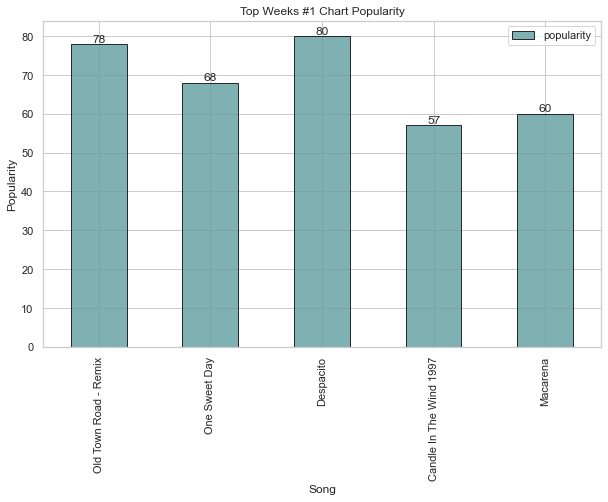

In [166]:
concat_1graph = concat_1.plot(figsize=(10,6),
                             x= 'name',
                             y= 'popularity',
                             title = 'Top Weeks #1 Chart Popularity',
                             xlabel = 'Song',
                             ylabel = 'Popularity',
                             kind = 'bar',
                             color = 'cadetblue',
                             edgecolor = 'black',
                             alpha = 0.8)
for bars in concat_1graph.containers:
    concat_1graph.bar_label(bars)
plt.show()

In [117]:
merge_1 = pd.concat([concat_1, position_df_5],keys=['concat_1', 'position_df_5'],
                 names=['name', 'Song'])
merge_1

album  \
name          Song                                                                                                    
concat_1      0                                                   {'album_type': 'single', 'artists': [{'externa...   
              1                                                   {'album_type': 'album', 'artists': [{'external...   
              2                                                   {'album_type': 'album', 'artists': [{'external...   
              3                                                   {'album_type': 'single', 'artists': [{'externa...   
              4                                                   {'album_type': 'album', 'artists': [{'external...   
position_df_5 (Old Town Road, Lil Nas X Featuring Billy Ray C...                                                NaN   
              (One Sweet Day, Mariah Carey & Boyz II Men)                                                       NaN   
              (Despacito, Luis Fonsi & Daddy Yankee Featuring...                                                NaN   
              (Candle In The Wind 1997/Something About The Wa...                                                NaN   
              (Macarena (Bayside Boys Mix), Los Del Rio)                                                        NaN   

                                                                                                            artists  \
name          Song                                                                                                    
concat_1      0                                                   [{'external_urls': {'spotify': 'https://open.s...   
              1                                                   [{'external_urls': {'spotify': 'https://open.s...   
              2                                                   [{'external_urls': {'spotify': 'https://open.s...   
              3                                                   [{'external_urls': {'spotify': 'https://open.s...   
              4                                                   [{'external_urls': {'spotify': 'https://open.s...   
position_df_5 (Old Town Road, Lil Nas X Featuring Billy Ray C...                                                NaN   
              (One Sweet Day, Mariah Carey & Boyz II Men)                                                       NaN   
              (Despacito, Luis Fonsi & Daddy Yankee Featuring...                                                NaN   
              (Candle In The Wind 1997/Something About The Wa...                                                NaN   
              (Macarena (Bayside Boys Mix), Los Del Rio)                                                        NaN   

                                                                                                  available_markets  \
name          Song                                                                                                    
concat_1      0                                                   [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              1                                                   [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              2                                                   [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              3                                                   [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
              4                                                   [AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...   
position_df_5 (Old Town Road, Lil Nas X Featuring Billy Ray C...                                                NaN   
              (One Sweet Day, Mariah Carey & Boyz II Men)                                                       NaN   
              (Despacito, Luis Fonsi & Daddy Yankee Featuring...                                                NaN   
              (Candle In The Wind 1997/Something About The Wa.

In [118]:
merge_1.to_csv('1_top_Weeks.csv')

In [119]:
merge_2 = pd.concat([merge, merge_1])
merge_2

album  \
name          Song                                                                                                    
concat_1      0                                                   {'album_type': 'album', 'artists': [{'external...   
              1                                                   {'album_type': 'album', 'artists': [{'external...   
              2                                                   {'album_type': 'album', 'artists': [{'external...   
              3                                                   {'album_type': 'album', 'artists': [{'external...   
              4                                                   {'album_type': 'compilation', 'artists': [{'ex...   
position_df_5 (Radioactive, Imagine Dragons)                                                                    NaN   
              (Sail, AWOLNATION)                                                                                NaN   
              (I'm Yours, Jason Mraz)                                                                           NaN   
              (Blinding Lights, The Weeknd)                                                                     NaN   
              (How Do I Live, LeAnn Rimes)                                                                      NaN   
concat_1      0                                                   {'album_type': 'single', 'artists': [{'externa...   
              1                                                   {'album_type': 'album', 'artists': [{'external...   
              2                                                   {'album_type': 'album', 'artists': [{'external...   
              3                                                   {'album_type': 'single', 'artists': [{'externa...   
              4                                                   {'album_type': 'album', 'artists': [{'external...   
position_df_5 (Old Town Road, Lil Nas X Featuring Billy Ray C...                                                NaN   
              (One Sweet Day, Mariah Carey & Boyz II Men)                                                       NaN   
              (Despacito, Luis Fonsi & Daddy Yankee Featuring...                                                NaN   
              (Candle In The Wind 1997/Something About The Wa...                                                NaN   
              (Macarena (Bayside Boys Mix), Los Del Rio)                                                        NaN   

                                                                                                            artists  \
name          Song                                                                                                    
concat_1      0                                                   [{'external_urls': {'spotify': 'https://open.s...   
              1                                                   [{'external_urls': {'spotify': 'https://open.s...   
              2                                                   [{'external_urls': {'spotify': 'https://open.s...   
              3                                                   [{'external_urls': {'spotify': 'https://open.s...   
              4                                                   [{'external_urls': {'spotify': 'https://open.s...   
position_df_5 (Radioactive, Imagine Dragons)                                                                    NaN   
              (Sail, AWOLNATION)                                                                                NaN   
              (I'm Yours, Jason Mraz)                                                                           NaN   
              (Blinding Lights, The Weeknd)                                                                     NaN   
              (How Do I Live, LeAnn Rimes)                                                                      NaN   
concat_1      0                                                

In [120]:
merge_2.to_csv('top_1_Weeks.csv')

In [121]:
weeks_graph

<AxesSubplot:title={'center':'Top Weeks on Chart'}, xlabel='Song', ylabel='Weeks On Chart'>

# Top Streams

# 1  Shape of You

In [122]:
shape = spotify.search({'track': 'Shape of You', 'artist': 'Ed'}, search_type ='track')
shape

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AShape+of+You+artist%3AEd&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6eUKZXaKkcviH0Ku9w2n3V'},
       'href': 'https://api.spotify.com/v1/artists/6eUKZXaKkcviH0Ku9w2n3V',
       'id': '6eUKZXaKkcviH0Ku9w2n3V',
       'name': 'Ed Sheeran',
       'type': 'artist',
       'uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'C

In [123]:
test = pd.DataFrame.from_dict(shape,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,25


In [124]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'single', 'artists': ..."
5,"{'album': {'album_type': 'single', 'artists': ..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'single', 'artists': ..."


In [126]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,233712,False,{'isrc': 'GBAHS1600463'},{'spotify': 'https://open.spotify.com/track/7q...,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,7qiZfU4dY1lWllzX7mPBI3,False,Shape of You,86,https://p.scdn.co/mp3-preview/09e92af512355474...,4,track,spotify:track:7qiZfU4dY1lWllzX7mPBI3
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,233712,False,{'isrc': 'GBAHS1600463'},{'spotify': 'https://open.spotify.com/track/0F...,https://api.spotify.com/v1/tracks/0FE9t6xYkqWX...,0FE9t6xYkqWXU2ahLh6D8X,False,Shape of You,68,https://p.scdn.co/mp3-preview/09e92af512355474...,1,track,spotify:track:0FE9t6xYkqWXU2ahLh6D8X
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,223573,False,{'isrc': 'GBAHS1700200'},{'spotify': 'https://open.spotify.com/track/5U...,https://api.spotify.com/v1/tracks/5ULRlgiSPSKT...,5ULRlgiSPSKTaJN1vU9yso,False,Shape of You - Acoustic,62,https://p.scdn.co/mp3-preview/c3eeae65fa146e70...,1,track,spotify:track:5ULRlgiSPSKTaJN1vU9yso
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,237664,False,{'isrc': 'GBAHS1700245'},{'spotify': 'https://open.spotify.com/track/5n...,https://api.spotify.com/v1/tracks/5nCtCCB5i1Of...,5nCtCCB5i1OfbADvynNw0i,False,Shape of You (feat. Zion & Lennox) - Latin Remix,56,https://p.scdn.co/mp3-preview/e04fa93c7b3fdd2d...,1,track,spotify:track:5nCtCCB5i1OfbADvynNw0i
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,192000,False,{'isrc': 'GBAHS1700228'},{'spotify': 'https://open.spotify.com/track/1K...,https://api.spotify.com/v1/tracks/1KqvRRQd3lfM...,1KqvRRQd3lfM0pAlkGPrgD,False,Shape of You (feat. Nyla & Kranium) - Major La...,53,https://p.scdn.co/mp3-preview/c23572bc1af607b4...,1,track,spotify:track:1KqvRRQd3lfM0pAlkGPrgD
5,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,195988,False,{'isrc': 'GBAHS1700196'},{'spotify': 'https://open.spotify.com/track/5H...,https://api.spotify.com/v1/tracks/5H7CwzYZ60e7...,5H7CwzYZ60e7w69tX4ivQN,False,Shape of You - Galantis Remix,49,https://p.scdn.co/mp3-preview/d08392e7f368ea88...,1,track,spotify:track:5H7CwzYZ60e7w69tX4ivQN
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,231260,False,{'isrc': 'GBAHS1700227'},{'spotify': 'https://open.spotify.com/track/2N...,https://api.spotify.com/v1/tracks/2NHSYwGkAvPH...,2NHSYwGkAvPHzCinY0KwXo,False,Shape of You - Stormzy Remix,54,https://p.scdn.co/mp3-preview/75c5ae296c5ca82c...,1,track,spotify:track:2NHSYwGkAvPHzCinY0KwXo
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,190097,False,{'isrc': 'GBAHS1700743'},{'spotify': 'https://open.spotify.com/track/1d...,https://api.spotify.com/v1/tracks/1dVWoeam7D1Z...,1dVWoeam7D1Zg6hB57pBE7,False,Shape of You - NOTD Remix,41,https://p.scdn.co/mp3-preview/534717fd2abbf931...,1,track,spotify:track:1dVWoeam7D1Zg6hB57pBE7
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,207128,True,{'isrc': 'GBAHS1700651'},{'spotify': 'https://open.s

In [127]:
shape_df = test3.head(1)

# 2 Blinding Lights

In [128]:
Blinding_Lights = spotify.search({'track': 'Blinding Lights', 'artist': 'The'}, search_type ='track')
Blinding_Lights

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ABlinding+Lights+artist%3AThe&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ'},
       'href': 'https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ',
       'id': '1Xyo4u8uXC1ZmMpatF05PJ',
       'name': 'The Weeknd',
       'type': 'artist',
       'uri': 'spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
    

In [129]:
test = pd.DataFrame.from_dict(Blinding_Lights,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,209


In [130]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'compilation', 'artis..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'compilation', 'artis..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [132]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,200040,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0V...,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,0VjIjW4GlUZAMYd2vXMi3b,False,Blinding Lights,91,https://p.scdn.co/mp3-preview/579494c4709a8cc9...,9,track,spotify:track:0VjIjW4GlUZAMYd2vXMi3b
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0G...,https://api.spotify.com/v1/tracks/0GbnoR2Z5Sg2...,0GbnoR2Z5Sg2j42EdcTU9F,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,4,track,spotify:track:0GbnoR2Z5Sg2j42EdcTU9F
2,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0w...,https://api.spotify.com/v1/tracks/0wvrycgQfH4s...,0wvrycgQfH4svzA4IM0p8S,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,5,track,spotify:track:0wvrycgQfH4svzA4IM0p8S
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0n...,https://api.spotify.com/v1/tracks/0naVx9FzYlE0...,0naVx9FzYlE0aJv4uaegHl,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,11,track,spotify:track:0naVx9FzYlE0aJv4uaegHl
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/1y...,https://api.spotify.com/v1/tracks/1yhPHuDyYVHi...,1yhPHuDyYVHi9EtTRzjpEx,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,11,track,spotify:track:1yhPHuDyYVHi9EtTRzjpEx
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/7G...,https://api.spotify.com/v1/tracks/7GkJMWlQfkER...,7GkJMWlQfkERJFT81ptWr5,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,13,track,spotify:track:7GkJMWlQfkERJFT81ptWr5
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0k...,https://api.spotify.com/v1/tracks/0k0HVjt1hUSB...,0k0HVjt1hUSB1i74oO1l0Z,False,Blinding Lights,4,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,3,track,spotify:track:0k0HVjt1hUSB1i74oO1l0Z
7,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/5I...,https://api.spotify.com/v1/tracks/5IatMb7tZdKB...,5IatMb7tZdKBSd5ro6R8ic,False,Blinding Lights,1,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,14,track,spotify:track:5IatMb7tZdKBSd5ro6R8ic
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/2H...,https://api.spotify.com/v1/tracks/2HdgAjQMeTBu...,2HdgAjQMeTBuGNCNPETL1b,False,Blindi

In [133]:
blinding_df = test3.head(1)

# 3 Dance Monkey

In [134]:
dance = spotify.search({'track': 'Dance Monkey', 'artist': 'Tones'}, search_type ='track')
dance

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ADance+Monkey+artist%3ATones&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2NjfBq1NflQcKSeiDooVjY'},
       'href': 'https://api.spotify.com/v1/artists/2NjfBq1NflQcKSeiDooVjY',
       'id': '2NjfBq1NflQcKSeiDooVjY',
       'name': 'Tones And I',
       'type': 'artist',
       'uri': 'spotify:artist:2NjfBq1NflQcKSeiDooVjY'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
   

In [135]:
test = pd.DataFrame.from_dict(dance,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'single', 'artists':..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,136


In [136]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'single', 'artists': ..."
1,"{'album': {'album_type': 'album', 'artists': [..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'compilation', 'artis..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'single', 'artists': ..."


In [138]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AZ, BA, BB, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/2X...,https://api.spotify.com/v1/tracks/2XU0oxnq2qxC...,2XU0oxnq2qxCpomAAuJY8K,False,Dance Monkey,78,https://p.scdn.co/mp3-preview/69bd9b5e4698ed9c...,2,track,spotify:track:2XU0oxnq2qxCpomAAuJY8K
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AZ, BA, BB, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/2N...,https://api.spotify.com/v1/tracks/2N8m6CYs74qQ...,2N8m6CYs74qQO4mjVcXO30,False,Dance Monkey,76,https://p.scdn.co/mp3-preview/967d568660220c5f...,16,track,spotify:track:2N8m6CYs74qQO4mjVcXO30
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AZ, BA, BB, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/5Z...,https://api.spotify.com/v1/tracks/5ZULALImTm80...,5ZULALImTm80tzUbYQYM9d,False,Dance Monkey,72,https://p.scdn.co/mp3-preview/69bd9b5e4698ed9c...,2,track,spotify:track:5ZULALImTm80tzUbYQYM9d
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AR, AT, AZ, BA, BB, BD, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/7K...,https://api.spotify.com/v1/tracks/7KfdeiE9f0ga...,7KfdeiE9f0gaNLrrRvT7Lw,False,Dance Monkey,0,https://p.scdn.co/mp3-preview/c6058e1bf9075ead...,6,track,spotify:track:7KfdeiE9f0gaNLrrRvT7Lw
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AZ, BA, BB, BD, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/1o...,https://api.spotify.com/v1/tracks/1ozHPtkOQhIt...,1ozHPtkOQhIthTD1VBP4pX,False,Dance Monkey,1,https://p.scdn.co/mp3-preview/c6058e1bf9075ead...,31,track,spotify:track:1ozHPtkOQhIthTD1VBP4pX
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AM, AZ, BD, BG, BH, BI, BN, BT, BW, CY, D...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/3x...,https://api.spotify.com/v1/tracks/3x8iDlzufI5b...,3x8iDlzufI5bf9yyvc4Onz,False,Dance Monkey,0,https://p.scdn.co/mp3-preview/c6058e1bf9075ead...,26,track,spotify:track:3x8iDlzufI5bf9yyvc4Onz
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AZ, BA, BB, B...",1,171461,False,{'isrc': 'USAT21905497'},{'spotify': 'https://open.spotify.com/track/1o...,https://api.spotify.com/v1/tracks/1ooBIqsmV1oc...,1ooBIqsmV1ocRldBZrvLPD,False,Dance Monkey - Stripped Back,50,https://p.scdn.co/mp3-preview/eaad182df7306e89...,1,track,spotify:track:1ooBIqsmV1ocRldBZrvLPD
7,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AG, AL, AM, AO, AR, AZ, BA, BB, BD, BE, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/03...,https://api.spotify.com/v1/tracks/03OHZnpZoELF...,03OHZnpZoELFxS7Jn5mT6L,False,Dance Monkey,41,https://p.scdn.co/mp3-preview/c6058e1bf9075ead...,14,track,spotify:track:03OHZnpZoELFxS7Jn5mT6L
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AZ, BA, BB, BD, B...",1,209438,False,{'isrc': 'QZES71982312'},{'spotify': 'https://open.spotify.com/track/7G...,https://api.spotify.com/v1/tracks/7GpNff36S1N4...,7GpNff36S1N4UE4c4ZUdrg,False,Dance Monk

In [139]:
dance_df = test3.head(1)

# 4 rockstar

In [140]:
rockstar = spotify.search({'track': 'rockstar', 'artist': 'Post'}, search_type ='track')
rockstar

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3Arockstar+artist%3APost&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/246dkjvS1zLTtiykXe5h60'},
       'href': 'https://api.spotify.com/v1/artists/246dkjvS1zLTtiykXe5h60',
       'id': '246dkjvS1zLTtiykXe5h60',
       'name': 'Post Malone',
       'type': 'artist',
       'uri': 'spotify:artist:246dkjvS1zLTtiykXe5h60'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
      'DE

In [141]:
test = pd.DataFrame.from_dict(rockstar,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,None
offset,0
previous,None
total,13


In [142]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'album', 'artists': [..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [144]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,218146,True,{'isrc': 'USUM71710087'},{'spotify': 'https://open.spotify.com/track/0e...,https://api.spotify.com/v1/tracks/0e7ipj03S05B...,0e7ipj03S05BNilyu5bRzt,False,rockstar (feat. 21 Savage),84,https://p.scdn.co/mp3-preview/1d16781160270b7e...,6,track,spotify:track:0e7ipj03S05BNilyu5bRzt
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,218146,False,{'isrc': 'USUM71710097'},{'spotify': 'https://open.spotify.com/track/19...,https://api.spotify.com/v1/tracks/19bX4zmC2zDb...,19bX4zmC2zDben2ldhoRB3,False,rockstar,54,https://p.scdn.co/mp3-preview/5d8a697c598b1959...,6,track,spotify:track:19bX4zmC2zDben2ldhoRB3
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,245946,True,{'isrc': 'USUM71713709'},{'spotify': 'https://open.spotify.com/track/4f...,https://api.spotify.com/v1/tracks/4fy6HNnu1XXq...,4fy6HNnu1XXq2j1Y56EP2H,False,rockstar - Remix,50,https://p.scdn.co/mp3-preview/14ab12f26660e9d7...,1,track,spotify:track:4fy6HNnu1XXq2j1Y56EP2H
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,218533,True,{'isrc': 'USUM71710087'},{'spotify': 'https://open.spotify.com/track/0p...,https://api.spotify.com/v1/tracks/0pFR9QNWbe74...,0pFR9QNWbe741iS5YjDCY4,False,rockstar,41,https://p.scdn.co/mp3-preview/a8ccbe065ce028bd...,20,track,spotify:track:0pFR9QNWbe741iS5YjDCY4
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,218320,True,{'isrc': 'USUM71710087'},{'spotify': 'https://open.spotify.com/track/2T...,https://api.spotify.com/v1/tracks/2TA2x6180Pwx...,2TA2x6180PwxPsbNeYyWZM,False,rockstar,33,https://p.scdn.co/mp3-preview/287ce57a966f9926...,17,track,spotify:track:2TA2x6180PwxPsbNeYyWZM
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,[US],1,217040,False,{'isrc': 'USUM71710097'},{'spotify': 'https://open.spotify.com/track/6H...,https://api.spotify.com/v1/tracks/6H6CxR0IS9ux...,6H6CxR0IS9ux9a0HWAlC0u,False,rockstar (feat. 21 Savage),16,https://p.scdn.co/mp3-preview/951383d67996db89...,7,track,spotify:track:6H6CxR0IS9ux9a0HWAlC0u
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,218066,True,{'isrc': 'USUM71710087'},{'spotify': 'https://open.spotify.com/track/3h...,https://api.spotify.com/v1/tracks/3hDYuWcvQE7y...,3hDYuWcvQE7yaMEeb2uiMI,False,rockstar,17,https://p.scdn.co/mp3-preview/be94c8863e6f915f...,2,track,spotify:track:3hDYuWcvQE7yaMEeb2uiMI
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,350714,False,{'isrc': 'GBDMT1600102'},{'spotify': 'https://open.spotify.com/track/1C...,https://api.spotify.com/v1/tracks/1CAHWnTq3kXJ...,1CAHWnTq3kXJjvmTAhcnqz,False,Rockstar,19,https://p.scdn.co/mp3-preview/330af4877b6296c8...,14,track,spotify:track:1CAHWnTq3kXJjvmTAhcnqz
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,218096,True,{'isrc': 'USUM71710087'},{'spotify': 'https://open.spotify.com/track/0I...,https://api.spotify.com/v1/tracks/0I2XhicZdPwy...,0I2XhicZdPwyDTtsCELdSf,False,rockstar,18,https://p.scdn.co/mp3-preview/ff6449dd085b8eb5...,1,t

In [145]:
rock_df = test3.head(1)

# 5 Someone You Loved

In [146]:
someone = spotify.search({'track': 'Someone You Loved', 'artist': 'Lewis'}, search_type ='track')
someone

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ASomeone+You+Loved+artist%3ALewis&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4GNC7GD6oZMSxPGyXy4MNB'},
       'href': 'https://api.spotify.com/v1/artists/4GNC7GD6oZMSxPGyXy4MNB',
       'id': '4GNC7GD6oZMSxPGyXy4MNB',
       'name': 'Lewis Capaldi',
       'type': 'artist',
       'uri': 'spotify:artist:4GNC7GD6oZMSxPGyXy4MNB'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY

In [147]:
test = pd.DataFrame.from_dict(someone,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,499


In [148]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_2283/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'compilation', 'artis..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'single', 'artists': ..."
5,"{'album': {'album_type': 'album', 'artists': [..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'single', 'artists': ..."


In [150]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,182160,False,{'isrc': 'DEUM71807062'},{'spotify': 'https://open.spotify.com/track/7q...,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,7qEHsqek33rTcFNT9PFqLf,False,Someone You Loved,87,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,4,track,spotify:track:7qEHsqek33rTcFNT9PFqLf
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,182160,False,{'isrc': 'DEUM71807062'},{'spotify': 'https://open.spotify.com/track/2T...,https://api.spotify.com/v1/tracks/2TIlqbIneP0Z...,2TIlqbIneP0ZY1O0EzYLlc,False,Someone You Loved,74,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,3,track,spotify:track:2TIlqbIneP0ZY1O0EzYLlc
2,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AU, BG, BH, CY, EE, EG, FI, GR, HK, ID, I...",1,189052,False,{'isrc': 'DEUM71901232'},{'spotify': 'https://open.spotify.com/track/1s...,https://api.spotify.com/v1/tracks/1swR83k1k3jF...,1swR83k1k3jFMs4hXALyWY,False,Someone You Loved - Future Humans Remix,0,https://p.scdn.co/mp3-preview/b0fb9c98e7452faa...,17,track,spotify:track:1swR83k1k3jFMs4hXALyWY
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,189052,False,{'isrc': 'DEUM71901232'},{'spotify': 'https://open.spotify.com/track/1e...,https://api.spotify.com/v1/tracks/1e8PAfcKUYoK...,1e8PAfcKUYoKkxPhrHqw4x,False,Someone You Loved - Future Humans Remix,62,https://p.scdn.co/mp3-preview/67703ba98bd455ec...,1,track,spotify:track:1e8PAfcKUYoKkxPhrHqw4x
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,157171,False,{'isrc': 'DEUM71900497'},{'spotify': 'https://open.spotify.com/track/1F...,https://api.spotify.com/v1/tracks/1FaMsrYFdk91...,1FaMsrYFdk914HDLQar1tz,False,Someone You Loved - Madism Radio Mix,62,https://p.scdn.co/mp3-preview/452f4ccbbbb78e5e...,1,track,spotify:track:1FaMsrYFdk914HDLQar1tz
5,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,182173,False,{'isrc': 'DEUM71807062'},{'spotify': 'https://open.spotify.com/track/0v...,https://api.spotify.com/v1/tracks/0vGWBo1b6KyE...,0vGWBo1b6KyE9klUQfxqwJ,False,Someone You Loved,49,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,4,track,spotify:track:0vGWBo1b6KyE9klUQfxqwJ
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,182160,False,{'isrc': 'DEUM71807062'},{'spotify': 'https://open.spotify.com/track/2X...,https://api.spotify.com/v1/tracks/2XfZTkN2rTMw...,2XfZTkN2rTMw4ncgdP0fY9,False,Someone You Loved,46,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,2,track,spotify:track:2XfZTkN2rTMw4ncgdP0fY9
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,182160,False,{'isrc': 'DEUM71807062'},{'spotify': 'https://open.spotify.com/track/3n...,https://api.spotify.com/v1/tracks/3nOeRG2FMaqB...,3nOeRG2FMaqBLvmGKaMgbU,False,Someone You Loved,46,https://p.scdn.co/mp3-preview/ae0a42ca5dca210c...,2,track,spotify:track:3nOeRG2FMaqBLvmGKaMgbU
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,208779,False,{'isrc': 'DEUM71903803'},{'spotify': 'https://open.spotify.com/track/5Y...,htt

In [151]:
someone_df = test3.head(1)

# Top Weeks

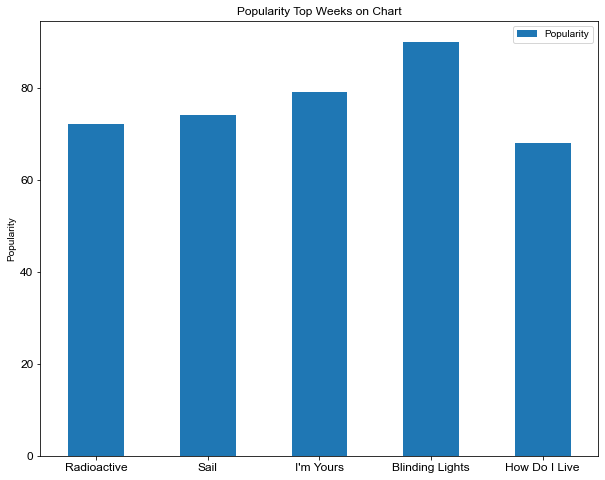

In [152]:
Title =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live']
Popularity = [ 72, 74, 79, 90, 68]


df = pd.DataFrame({'Popularity' : Popularity }, index = Title)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Popularity Top Weeks on Chart', ylabel= 'Popularity')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

# Top Weeks BPM

In [153]:
Top_weeks_BPM = ['Radioactive','Sail', "I'm Yours", 'Blinding Lights','How Do I Live']
top_BPM_df = pd.DataFrame(Top_weeks_BPM)
Top_weeks_BPM_2= [136,119,151,171,128]
top_BPM_df_2= pd.DataFrame(Top_weeks_BPM_2)
concat_BPM_1 = pd.concat([top_BPM_df, top_BPM_df_2], ignore_index=False)
concat_BPM_1

,0
0,Radioactive
1,Sail
2,I'm Yours
3,Blinding Lights
4,How Do I Live
0,136
1,119
2,151
3,171
4,128


# 1 Weeks

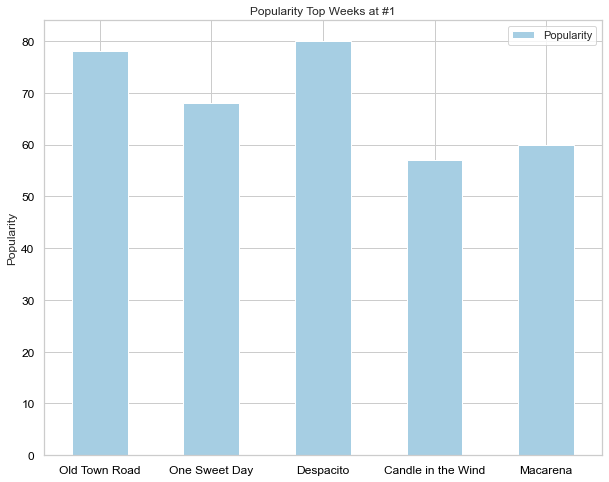

In [154]:
Title =  ['Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena']
Popularity = [78, 68, 80, 57, 60]


df = pd.DataFrame({'Popularity' : Popularity }, index = Title)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Popularity Top Weeks at #1', ylabel= 'Popularity')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

# Combined Chart Weeks

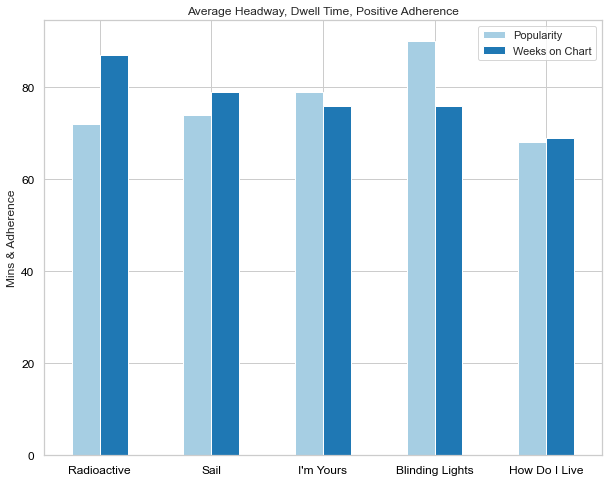

In [155]:
group_labels =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live']
Popularity = [ 72, 74, 79, 90, 68]

Weeks_on_Chart = [87, 79, 76, 76, 69]


df = pd.DataFrame({'Popularity': Popularity, 'Weeks on Chart': Weeks_on_Chart}, index = group_labels)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Average Headway, Dwell Time, Positive Adherence', ylabel= 'Mins & Adherence')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

# Combined Chart #1

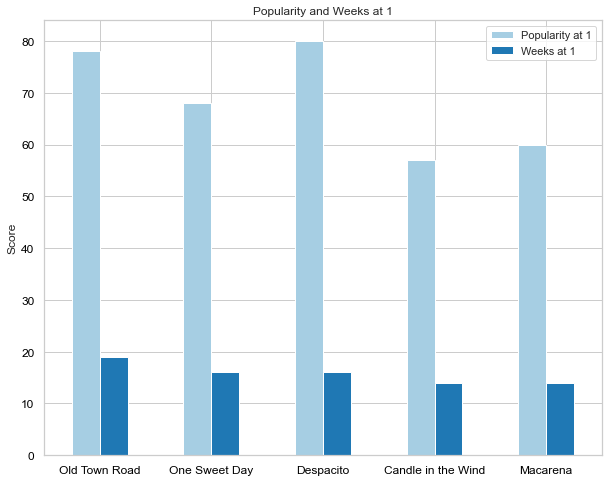

In [156]:
group_labels =  ['Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena' ]

Popularity_at_1= [78, 68, 80, 57, 60]

Weeks_at_1 = [19, 16, 16, 14, 14]

df = pd.DataFrame({'Popularity at 1': Popularity_at_1, 'Weeks at 1': Weeks_at_1}, index = group_labels)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Popularity and Weeks at 1', ylabel= 'Score')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

# Combined Chart

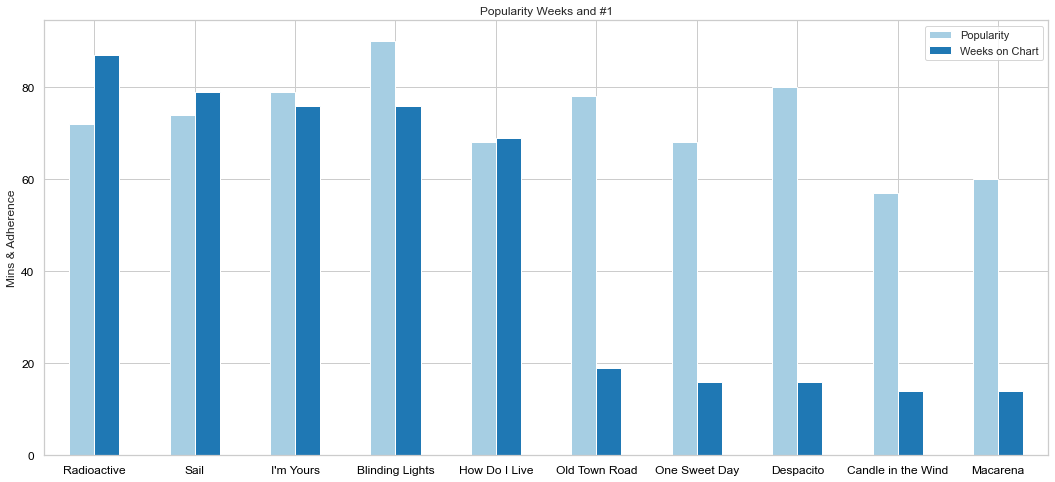

In [157]:
group_labels =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live', 'Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena' ]

Popularity = [ 72, 74, 79, 90, 68, 78, 68, 80, 57, 60]

Weeks_on_Chart = [87, 79, 76, 76, 69, 19, 16, 16, 14, 14]


df = pd.DataFrame({'Popularity': Popularity, 'Weeks on Chart': Weeks_on_Chart}, index = group_labels)

ax = df.plot(kind='bar', figsize=(18,8), rot=0, title = 'Popularity Weeks and #1', ylabel= 'Mins & Adherence')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()


# Combined Chart Just Weeks

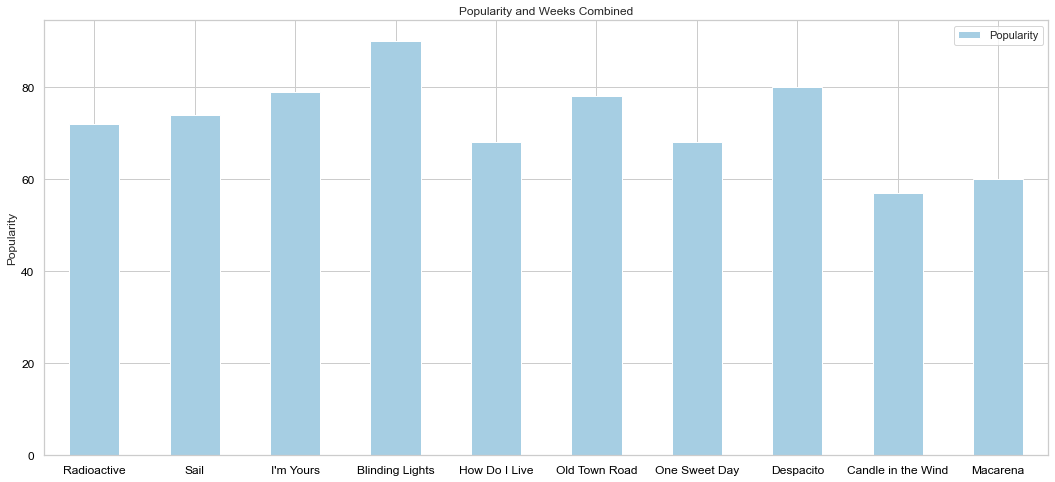

In [158]:
Title =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live', 'Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena']
Popularity = [ 72, 74, 79, 90, 68, 78, 68, 80, 57, 60]


df = pd.DataFrame({'Popularity' : Popularity }, index = Title)

ax = df.plot(kind='bar', figsize=(18,8), rot=0, title = 'Popularity and Weeks Combined', ylabel= 'Popularity')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()